<h1>Assignment Submission </h1>

<h3> Advanced Data Analytics for Management Support, Summer 2022</h3>

Johann Sonnenburg

### Contents
1. [Introduction](#introduction)
2. [Data Loading and Preliminary Cleaning](#data_loading+cleaning)
    1. [Data Loading](#data_loading)
    2. [Initial Feature Extraction](#feat_extract)
    3. [Data Quality](#data_qual)
3. [Non-Text Features](#nontext)
    1. [Data Exploration](#dataexplor_nontext)
    2. [Feature Engineering](#feat_eng_nontext) 
    3. [Handling Missing Values and Final Processing](#missing_values_nontext)
3. [Text Features](#text)
    1. [Text Preprocessing](#text_preprocessing)
    2. [Data Exploration](#dataexplor_text)
    3. [Text Preparation](#text_preparation)
6. [Model Building](#modeling)
    1. [Data Preparation](#data_prep)
    2. [Non-Text Features](#models_nontext)
    3. [Text Features](#models_text)
    4. [All Features](#models_all)
        1. [Naive Combination](#naive_comb)
        2. [Model Stacking](#model_stacking)
        3. [Concatenated Neural Network](#conc_nn)
7. [Conclusion](#conclusion)

## 1. Introduction <a name="introduction"></a>
In this analysis, we aim to predict the prices of Airbnb listings in London.
Available to us is data on more than 55,000 properties containing the listings' features in a tabular format (e.g., their location, the number of bedrooms, and the property type), several text features such as the listings' descriptions, and the rental price per night for each property. We additionally have access to the reviews for these properties written by guests on the Airbnb platform.

A large share of this analysis will be concerned with data cleaning and preprocessing. For our predictive models, we examine how to best combine the text and tabular data available to us while also testing several different modeling approaches. We conclude by using the best one of these models to obtain predictions for the test set.

As for the structure of this analysis; Section 2 is concerned with loading the data, performing some initial cleaning and feature extraction, and some data quality checks. The following section deals in detail with the tabular data and comprises an extensive exploratory analysis of the data, as well as some feature engineering. It also comprises a missing value analysis. In Section 4, we preprocess the text data and explore it before preparing it for the subsequent section. Section 5 comprises some final data preparations and the predictive models for the individual data subsets as well as for the whole dataset. The analysis is completed by a short conclusion.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import re
from textblob import TextBlob
import missingno as msno
import geopy.distance
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from collections import Counter

import preprocessing as pre
import model_stacking as ms
import model_evaluation as me

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from keras.layers import Dropout, Dense, Input, LSTM, concatenate
from keras import Model, losses
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import os

import warnings
warnings.filterwarnings("ignore")

/Users/johann/miniforge3/envs/d2l/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 2. Data Loading and Preliminary Cleaning <a name="data_loading+cleaning"></a>
After loading the data and a brief initial check of the data quality, we start by performing some feature extraction, as a significant share of the variables in our dataset cannot be used in their current format. During this step, we additionally deal with the review data that is available to us and try to extract meaningful information from it. This section concludes with a more extensive verification of the quality of our data and some related cleaning.

### 2a. Data Loading <a name="data_loading"></a>

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

Our first steps are to check whether the training and test set are clean in the sense that all the listing IDs are unique and whether they differ in any variables other than the target.

In [3]:
print('No duplicate listing IDs in training set:',(train['listing_id'].unique() == train['listing_id']).all())
print('No duplicate listing IDs in test set:',(test['listing_id'].unique() == test['listing_id']).all())

No duplicate listing IDs in training set: True
No duplicate listing IDs in test set: True


In [4]:
print('Columns in train and test set differ in element:', np.setdiff1d(train.columns, test.columns)[0])

Columns in train and test set differ in element: price


Before proceeding further, we will convert several features that only take on integer values to the appropriate data type.

In [5]:
train = pre.cols_to_int(train)
test = pre.cols_to_int(test)

### 2b. Initial Feature Extraction <a name="feat_extract"></a>
#### Amenities
Right now, the 'amenities' feature consists of a list of amenities for each listing that varies in length.
In order to make it useable for a predictive model, we will need to transform it.

In [6]:
# remove curly braces and quotation marks which are used irregularly
train = pre.clean_amenities(train)
test = pre.clean_amenities(test)

Below are the ten amenities which are most frequently included in all listings within the training set.

In [7]:
train.amenities.apply(lambda x: x.split(',')).explode().value_counts()[0:10]

Wifi              53049
Heating           52332
Essentials        51668
Kitchen           50471
Smoke detector    47733
Washer            47083
Hangers           44415
Iron              42213
Hair dryer        38954
Shampoo           37855
Name: amenities, dtype: int64

We suspect that some of these amenities, if included in an Airbnb listing, have a stronger effect on the listing's price than others. The same holds for all other amenities. For each amenity we will thus look at the average listing price together with the standard deviation for all listings that feature this specific amenity, as well as the average deviation from the overall mean price. Additionally, we examine the absolute correlation of the occurence of an amenity with the target variable. Commonly, the higher the correlation is in magnitude, the better of a predictor a variable is suspected to be. Our feature extraction will then focus on the twenty amenities with the strongest absolute correlation with the listing price, where we require each amenity to be included in at least 5,000 listings. The table below lists the twenty chosen amenities together with the mentioned descriptive statistics.

In [8]:
top20 = pre.get_top_amenities(train).head(20); top20

,amenity,mean_price,std_price,dev_from_mean,abs_corr_with_target,included_in
10,TV,121.15,89.31,53.40,0.30,37848
27,Dishwasher,143.00,99.83,50.13,0.25,12612
14,Dryer,124.24,93.52,35.34,0.21,24105
26,Lock on bedroom door,75.20,69.42,38.09,0.19,13035
25,Private entrance,128.75,88.48,32.36,0.17,13524
24,Family/kid friendly,126.32,89.88,30.08,0.16,14837
31,Coffee maker,130.45,95.73,33.11,0.16,11633
7,Iron,111.98,86.41,32.43,0.16,42213
17,Oven,121.32,91.02,27.13,0.16,20625
21,Stove,121.72,90.71,26.21,0.15,18554


For each of the selected amenities, we will create a new dummy feature, which will be equal to one if a listing includes the amenity and zero otherwise.

In [9]:
train = pre.create_amenity_dummies(train, top20)

We now recreate these features for the test set.

In [10]:
test = pre.create_amenity_dummies(test, top20)

Finally, we drop the original column from the datasets.

In [11]:
train.drop('amenities', 1, inplace=True)
test.drop('amenities', 1, inplace=True)

#### Host Reponse Rate

The host response rate is not valuable in its current format. To make it useable, we will turn it into a decimal number.

In [12]:
train.host_response_rate = train.host_response_rate.astype(str).apply(lambda x: float(x.strip('%')) / 100)
test.host_response_rate = test.host_response_rate.astype(str).apply(lambda x: float(x.strip('%')) / 100)

#### Dummies - Superhost & Verified Identity
The dataset features two binary variables that we will code to integer numbers in order to make them properly processable.

In [13]:
train['host_is_superhost'] = train['host_is_superhost'].map({'t': 1, 'f': 0})
test['host_is_superhost'] = test['host_is_superhost'].map({'t': 1, 'f': 0})

In [14]:
train['host_identity_verified'] = train['host_identity_verified'].map({'t': 1, 'f': 0})
test['host_identity_verified'] = test['host_identity_verified'].map({'t': 1, 'f': 0})

#### Distance from the City Center

We will use the latitude and longitude to calculate the distance from London's city center (in km) for each listing, as we suspect this value to have a strong correlation with a listing's price. We expect a listing to, on average, have a higher price the closer it is to the city center, as this makes it more attractive to potential guests. This relationship will be verified later in our analysis. Here, London's center is defined as Trafalgar Square, located at a latitude of 51.5085 and a longitude of -0.1282 as per [this source](https://www.findlatitudeandlongitude.com/l/Trafalgar+Square%2C+London%2C+United+Kingdom/4196266/).

In [15]:
center_london = (51.5085, -0.1282)

train['distance_from_center'] = [geopy.distance.geodesic(coord, center_london).km for coord in zip(train.latitude, train.longitude)]
test['distance_from_center'] = [geopy.distance.geodesic(coord, center_london).km for coord in zip(test.latitude, test.longitude)]

#### Days as Host

As the variable displaying the hosts' signup dates to the Airbnb platform is not useable in its current format, we decide to transform it into a feature that measures the total days that a host has been using Airbnb. To approximate this value, we first obtain the latest date present in the training set, which we assume to be the date on which the dataset was created. We then compute the time period (in days) between this date and each host's signup date ('host_since').

In [16]:
train.host_since.sort_values(ascending=False).head(1) # latest date is January 8, 2020

45251    2020-01-08
Name: host_since, dtype: object

In this process, we are required to deal with the missing values for this variable before performing any calculations. During this step, we set a flag to indicate a missing value for a listing. Once the new variable is defined successfully, the old feature ('host_since') is dropped. We perform all of these steps at once below.

In [17]:
train = pre.compute_days_as_host(train)
test = pre.compute_days_as_host(test)

#### Total Listings Count

We notice that the count of total listings is zero for some hosts. However, looking at the training set, for each hosts in question, we will thus count their respective number of listings and insert this value into the feature column.

Here, we assume that 'host_total_listings_count' is the total number of listings published by a host, thus a count of zero would not be logical given that a host would need to have published at least one listing in order to be included in the dataset.

In [18]:
train = pre.clean_total_listings_count(train)

We apply the same procedure to the test set.

In [19]:
test = pre.clean_total_listings_count(test)

#### Text Reviews
In addition to the overall review scores, we have access to another dataset containing the guests' reviews for each listing, which are in a text format.

We will process these with the goal of turning them into a numeric feature representing the average sentiment of each listing's reviews. To facilitate this processing step, we will restrict the reviews to include only those written in English.

In [20]:
reviews = pd.read_csv('data/reviews.csv')

In [21]:
reviews.head()

,reviewer_id,comments,review_id,listing_id
0,93896,"The flat was bright, comfortable and clean and...",30672,8Z94Z3WMCO
1,97890,We stayed with Adriano and Valerio for a week ...,32236,8Z94Z3WMCO
2,104133,Adriano was a fantastic host. We felt very at ...,41044,8Z94Z3WMCO
3,122714,We had a most wonderful stay with Adriano and ...,48926,8Z94Z3WMCO
4,111543,I'm not sure which of us misunderstood the s...,58352,8Z94Z3WMCO


We first check whether there exist duplicate reviews (as indicated by their ID).

In [22]:
len(reviews.review_id.unique()) == len(reviews)

False

Because there do indeed exist duplicate reviews, we decide to keep only the first occurence of each review ID.

In [23]:
reviews.drop_duplicates('review_id', inplace=True, keep='first')

Moving on, we briefly note what share of listings in the training and test set are linked to a review in the reviews dataset.

In [24]:
c1 = train.listing_id.isin(reviews.listing_id)
print('Share of listings in training set with review in reviews data:',np.round((sum(c1)/len(train)),2))

c2 = test.listing_id.isin(reviews.listing_id)
print('Share of listings in test set with review in reviews data:',np.round((sum(c2)/len(test)),2))

Share of listings in training set with review in reviews data: 0.78
Share of listings in test set with review in reviews data: 0.78


This indicates that we will eventually need to deal with the missing values for the final sentiment score. In addition, some of the entries in the reviews dataset are missing the actual review, which we will set a flag for.

In [25]:
reviews['flag_missing_comment'] = reviews['comments'].isnull().astype(int)

reviews.comments.fillna('', inplace=True)

We are now ready to detect the language of each review. Recall that we will limit the analysis to English reviews.

In [26]:
LANGUAGE = pre.LanguageIdentification()

reviews['lang'] = reviews['comments'].apply(lambda x: LANGUAGE.predict_lang(x.replace("\n"," "))[0][0])

Using the predicted language, we will restrict the dataset to the desired subset.

In [27]:
reviews = reviews[reviews['lang'] == '__label__en']

We will briefly clean the reviews to make them ready for further processing.

In [28]:
pattern = "The host canceled this reservation.*"

mask = reviews['comments'].str.contains(pattern)

reviews = reviews[~mask]

In [29]:
reviews['comments'] = reviews['comments'].apply(lambda x: pre.remove_nonascii(x))
reviews['comments'] = reviews['comments'].apply(lambda x: pre.remove_whitespace(x))
reviews['comments'] = reviews['comments'].apply(lambda x: pre.remove_punctuation_and_casing(x))

Now we are ready to predict each review's sentiment score, which will be in the range of -1 and 1, where -1 and 1 are the most negative and the most positive score, respectively.

In [30]:
reviews['sentiment'] = reviews['comments'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [31]:
# re-insert NA values
reviews.loc[(reviews['flag_missing_comment'] == 1), 'sentiment'] = np.nan

In [32]:
# group sentiment score by each listing and save in new table
reviews_score = pd.DataFrame(reviews.groupby('listing_id')['sentiment'].agg('mean'))

We can then append the score feature to our training and test sets.

In [33]:
train = pre.process_sentiment_score(train, reviews_score)
test = pre.process_sentiment_score(test, reviews_score)

Share of listings with sentiment score in training set: 0.74
Share of listings with sentiment score in test set: 0.75


### 2c. Data Quality <a name="data_qual"></a>
#### Duplicate Listings

Last but not least, we will check whether the training set contains any duplicate listings. We assume that duplicate listings would either share the same name or the same picture URL.

In [34]:
train.name.value_counts()[0:5]

Double room                                          28
Centrally Located Tower Hill/Aldagte East Studios    17
Luxury 3 Bed Two Minutes from Shoreditch Station     16
Luxury 2 bedroom in Central London                   15
Single room                                          14
Name: name, dtype: int64

Looking at how many times each name is present in the training set, we find several listing names to occur multiple times. We examine one of these in more detail.

In [35]:
train[train['name'] == 'Luxury 3 Bed Two Minutes from Shoreditch Station'][['host_id', 'host_total_listings_count']]

,host_id,host_total_listings_count
2411,2331446,66.0
2959,207477735,41.0
2975,248034547,43.0
18707,207477735,41.0
20915,207477735,41.0
24149,207477735,41.0
30759,248034547,43.0
35869,207477735,41.0
36955,2331446,66.0
37067,2331446,66.0


We conclude that listings with identical names tend to result from these names being very generic, or from these listings being in the same building and posted by the same, usually professional, host.

Additionally, we notice duplicates in listings' picture URL.

In [36]:
train.picture_url.value_counts()[:5]

https://a0.muscache.com/im/pictures/d029c664-c280-4eec-ad56-8ceca3b3d1cc.jpg?aki_policy=large    7
https://a0.muscache.com/im/pictures/a9390b68-2217-4c9b-8365-26bd5fd8b573.jpg?aki_policy=large    6
https://a0.muscache.com/im/pictures/96d7a914-0f6b-4195-9097-3f62a19ca7dd.jpg?aki_policy=large    6
https://a0.muscache.com/im/pictures/65ac2eba-1776-476c-a4b4-fa2c8cad80f7.jpg?aki_policy=large    5
https://a0.muscache.com/im/pictures/eb043344-c691-45cd-b9ad-255e6c0f9058.jpg?aki_policy=large    5
Name: picture_url, dtype: int64

We again take a closer look at one of these.

In [37]:
train[train['picture_url'] == train.picture_url.value_counts().index[0]][0:5]

,host_id,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,...,hosting_amenity_50,washer,kitchen,microwave,cable_tv,long_term_stays_allowed,distance_from_center,flag_host_since_missing,days_as_host,sentiment
8298,48165024,"One Bedroom Flat, Sloane Avenue - CC",This one bed flat is located in Chelsea Cloist...,NaN,This one bed flat is located in Chelsea Cloist...,none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/d029c664-c...,...,1,0,1,1,0,0,3.295693,0,1526.0,missing
12004,48165024,Sloane Avenue located One Bedroom Apt - CC,This one bed flat is located in Chelsea Cloist...,NaN,This one bed flat is located in Chelsea Cloist...,none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/d029c664-c...,...,1,0,1,1,0,0,3.224145,0,1526.0,positive
19966,48165024,Superb One Bedroom Apartment - Chelsea - CC,This one bed flat is located in Chelsea Cloist...,"The apartment includes: Towels, bedding, soap ...",This one bed flat is located in Chelsea Cloist...,none,NaN,"- To check in, you must go to the reception at...",NaN,https://a0.muscache.com/im/pictures/d029c664-c...,...,1,0,1,1,0,0,3.237074,0,1526.0,excellent
21079,48165024,One Bedroom with Sofabed sleeping 3 - CC,This one bed flat is located in Chelsea Cloist...,NaN,This one bed flat is located in Chelsea Cloist...,none,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/d029c664-c...,...,1,0,1,1,0,0,3.354297,0,1526.0,missing
23618,48165024,Superb One Bedroom Apartment in Chelsea - CC,This one bed flat is located in Chelsea Cloist...,"The apartment includes: Towels, bedding, soap ...",This one bed flat is located in Chelsea Cloist...,none,NaN,Sloane Square Tube Station - 10 minute walk S...,NaN,https://a0.muscache.com/im/pictures/d029c664-c...,...,1,0,1,1,0,0,3.284244,0,1526.0,positive


The reason for this is similar as before: these listings are most likely in same large apartment building. Thus, we expect them to not pose an issue, especially given that this concerns only a negligible share of all listings in the dataset.

#### Redundant and Uninformative Features

Lastly, we remove all redundant or uninformative features.

The variable 'neighbourhood' contains the same information as 'neighbourhood_cleansed' and will thus be dropped, while the host ID does not contain any information that we would like our model to pick up and will therefore be removed as well. Since only very few hosts in the dataset do not have a profile picture, we will also drop this variable from the dataset.

In [38]:
train.drop('neighbourhood', axis = 1, inplace = True)
test.drop('neighbourhood', axis = 1, inplace = True)

In [39]:
train.drop('host_id', axis = 1, inplace = True)
test.drop('host_id', axis = 1, inplace = True)

In [40]:
train.drop('host_has_profile_pic', 1, inplace=True)
test.drop('host_has_profile_pic', 1, inplace=True)

## 3. Non-Text Features <a name="nontext"></a>
In this part, we first perform a thorough exploratory analysis of various non-text features and their relation to the target variable before using the insights we obtained during this analysis to conduct some feature engineering and transformation. Lastly, we analyze and treat the missing values in this part of our dataset.

### 3a. Data Exploration <a name="dataexplor_nontext"></a>
#### Price
Before diving deeper into some of the non-text features, we briefly examine the distribution of the target variable, the price of an Airbnb listing. We notice some outliers on the upper end of the distribution, which, upon closer analysis, turn out to be real listings. Thus, we decide to leave the values for these listings as they are.

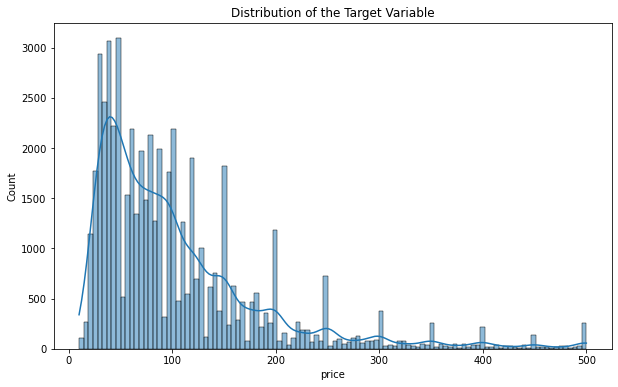

In [41]:
plt.figure(figsize=(10,6))
sns.histplot(train.price, kde = True)
plt.title('Distribution of the Target Variable');

The target variable appears to follow an approximate log-normal distribution. We could transform it to make it conform more to our distributional assumptions for, e.g., a linear regression. However, we should in general refrain from changing the target distribution as this would subsequently distort the information conveyed to the models we use for prediction.

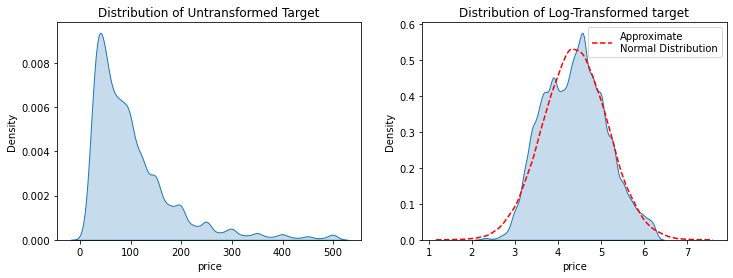

In [42]:
plt.figure(figsize=(12,4))

plt.subplot(121)
sns.kdeplot(train.price, shade = True)
plt.title('Distribution of Untransformed Target')

plt.subplot(122)
sns.kdeplot(np.log(train.price), shade = True)
value = np.random.normal(loc=4.4,scale=0.75,size=100000)
sns.kdeplot(value, color='red', linestyle="--", label='Approximate\nNormal Distribution')
plt.legend()
plt.title('Distribution of Log-Transformed target');

#### Correlation Analysis
Before diving deeper into the relationship of selected features and the target variable, we will investigate the correlation plot including all the features present in our dataset at this point.

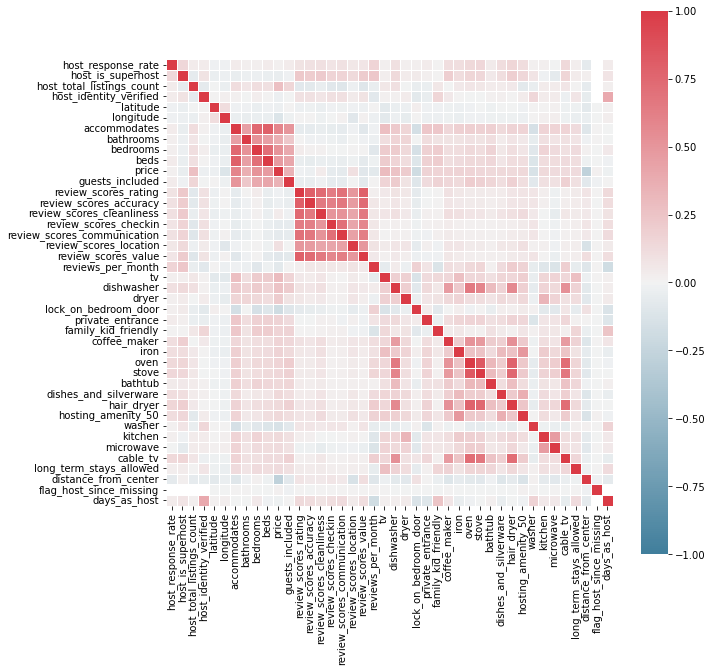

In [43]:
plt.figure(figsize=(10,10))

corr = train.corr()

cmap = sns.diverging_palette(230, 10, as_cmap=True)

sns.heatmap(corr, square=True, linewidths=0.5, cmap=cmap, vmin=-1);

Focusing on the correlation of the target variable, the listing price, with all other variables, we note a surprisingly strong positive correlation with the total number of listings of a host. We suspect that this may be due to these hosts being able to either charge more for their listings because they are more professional or because they tend to offer a higher quality stay.  As we would expect, a listing's price appears to also be positively correlated with the number of guests it can host (as conveyed by 'accommodates', 'bedrooms', and 'beds'). Almost all amenities are positively correlated with the target, with the exceptions being a lock on the bedroom door and a washer. Interestingly, the review scores are only mildly correlated with the price. Generally, we observe clusters of positive correlation between all the review scores, and between most of the amenities, which is in line with our expectations. Finally, as we would have expected, listings farther away from the city center tend to be priced lower than those closer to it, as indicated by a negative correlation coefficient.

#### Neighbourhood
The first feature we will examine closer is the neighbourhood. Specifically, we will examine how the average price differs between the most and the least expensive neighbourhoods.

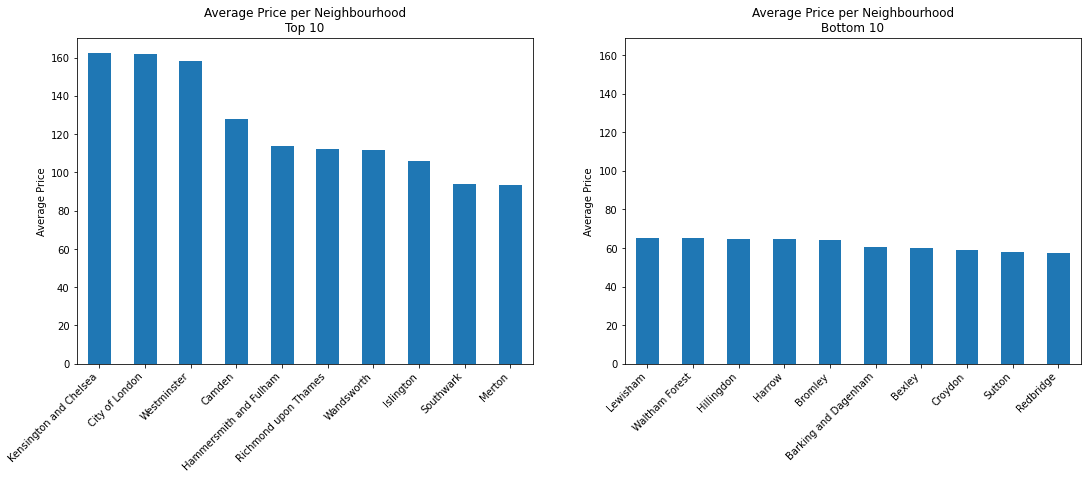

In [44]:
plt.figure(figsize=(18,6))

plt.subplot(121)

train.groupby("neighbourhood_cleansed")["price"].agg("mean").sort_values(ascending=False).head(10).plot.bar()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Price')
plt.xlabel('')
plt.title('Average Price per Neighbourhood\nTop 10');

plt.subplot(122)

train.groupby("neighbourhood_cleansed")["price"].agg("mean").sort_values(ascending=False).tail(10).plot.bar()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average Price')
plt.xlabel('')
plt.ylim(0, 169)
plt.title('Average Price per Neighbourhood\nBottom 10')

plt.suptitle;

We note a substantial difference in the average price between the different neighbourhoods. Listings in the most expensive neighbourhoods are more than double the price of those in the least expensive neighbourhoods, on average. This indicates that this variable will be useful to keep as a feature. 

#### Offered Experiences
Another potentially interesting variable to consider is the experience offered together with a listing. Hypothetically, certain experiences would increase a listing's price quite considerably. We look to investigate whether this holds in our dataset and if we can use this feature to make predictions.

In [45]:
train.experiences_offered.value_counts()

none        54222
business      364
family        300
social        266
romantic      132
Name: experiences_offered, dtype: int64

In [46]:
test.experiences_offered.value_counts()

none        29194
business      208
family        166
social        134
romantic       67
Name: experiences_offered, dtype: int64

Looking at how many listings offer an experience, we immediately notice that these add up to only around two percent of all listings in total.

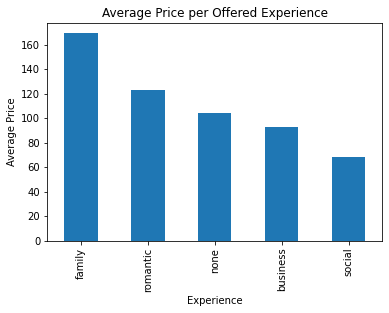

In [47]:
train.groupby("experiences_offered")["price"].agg("mean").sort_values(ascending=False).plot.bar()
plt.title('Average Price per Offered Experience')
plt.ylabel('Average Price')
plt.xlabel('Experience');

However, we also note that the average listing price varies quite substantially by the offered experience. Whether this is actually due to the experience being offered or because of other factors is of course up to debate. To check whether the higher average is caused by one or multiple outliers, we examine the price distribution of the listings that offer a family experience compared to that of all listings that do not offer any experiences.

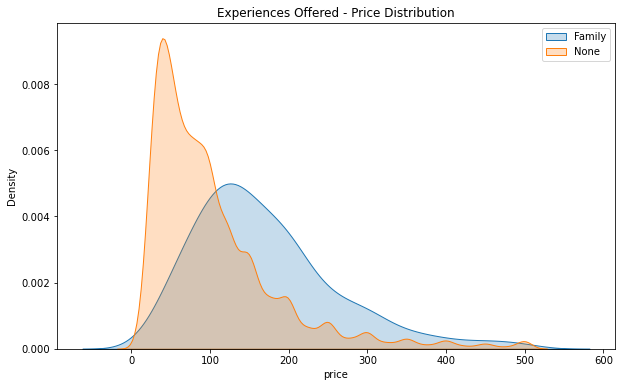

In [48]:
x = train[train['experiences_offered'] == 'family']['price']
y = train[train['experiences_offered'] == 'none']['price']

fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(x, ax=ax, shade=True, label='Family')
sns.kdeplot(y, ax=ax, shade=True, label='None')
plt.legend()
plt.title('Experiences Offered - Price Distribution');

We conclude that outliers are not causing the higher average price. Airbnb listings that offer a family experience tend to simply be more expensive than other listings. For the other possible experiences, we suspect to observe something similar.

Nonetheless, because of the overall low case count for all experiences, we decide to exlude this variable from our dataset.

In [49]:
train.drop('experiences_offered', 1, inplace=True)
test.drop('experiences_offered', 1, inplace=True)

#### Host - Total Listings Count
After previously cleaning up this variable, we are now ready to explore its connection to the target variable in more detail. Immediately, we notice an outlier on the upper end of the variable distribution.

In [50]:
train['host_total_listings_count'].describe()

count    55173.000000
mean        20.810850
std        117.012921
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       1321.000000
Name: host_total_listings_count, dtype: float64

Looking at some of the concerned listings, we determine that this outlier is a legitimate value as the host in question appears to be running a professional business.

In [51]:
train[train['host_total_listings_count'] == 1321].head(5)

,name,summary,space,description,neighborhood_overview,transit,house_rules,picture_url,host_response_time,host_response_rate,...,hosting_amenity_50,washer,kitchen,microwave,cable_tv,long_term_stays_allowed,distance_from_center,flag_host_since_missing,days_as_host,sentiment
179,Beautiful 1 bed flat in luxurious Kensington,This charming 1 bedroom flat is set over 2 flo...,LIVING ROOM With high ceilings and a charming...,This charming 1 bedroom flat is set over 2 flo...,"Blythe Road, Shepherd’s Bush Road and Hammersm...",Walk 10 minutes to Barons Court Station which ...,- The lead guest will be required to sign an O...,https://a0.muscache.com/im/pictures/38a39c86-c...,within an hour,0.97,...,0,0,1,1,1,1,6.236075,0,1693.0,positive
465,"Charming 2 BR home, 2 mins from the tube (Veeve)","A lovely Hampstead home, with country-style ch...","Situated on a small private cobbled path, this...","A lovely Hampstead home, with country-style ch...","Situated in the lovely area of Hampstead, whic...",This property is conveniently located just a 2...,"- No pets, no parties or smoking, please. - Th...",https://a0.muscache.com/im/pictures/9f6a19bf-b...,within an hour,0.97,...,0,0,1,1,1,0,7.694328,0,1693.0,missing
791,3BR garden & terrace near London Fields (Veeve),"Complete with a pretty garden, as well as a ro...",At the front of the home is a welcoming front ...,"Complete with a pretty garden, as well as a ro...",This home is situated in Dalston- an arty and ...,This home is equidistant from several differen...,"- No pets, no parties or smoking, please. - T...",https://a0.muscache.com/im/pictures/60a8b6ec-c...,within an hour,0.97,...,0,0,1,1,1,0,5.843378,0,1693.0,missing
887,Up to 20% off! Littler Venice,This home is situated within a modern complex ...,HOME HIGHLIGHTS • Canal views • Convenient loc...,This home is situated within a modern complex ...,This property is located in London's 'Little V...,INTO TOWN You are 2 minutes away from Paddingt...,- The lead guest will be required to sign an O...,https://a0.muscache.com/im/pictures/2f1b5b5e-f...,within an hour,0.97,...,0,0,1,1,0,0,3.651189,0,1693.0,missing
922,Bright & Modern 3BR by the Cutty Sark (Veeve),Situated in pretty Greenwich in South-East Lon...,This home is situated on the 3rd floor of the ...,Situated in pretty Greenwich in South-East Lon...,Greenwich is home to the nearby National Marit...,Greenwich DLR station is a 1 minute walk from ...,"- No pets, no parties or smoking, please. - T...",https://a0.muscache.com/im/pictures/1ecd81f6-3...,within an hour,0.97,...,0,0,1,1,1,0,8.548902,0,1693.0,missing


Due to the variable distribution being so skewed, we decide that it could be worth turning it into a categorical variable. This will also heavily mitigate the effect of the outlier. We look into the average listing price for each defined category and note that it is especially high for hosts with a great number of total listings, a connection which we already noted during the correlation analysis.

In [52]:
bins = [0, 1, 5, 1500]
labels = ['1', '2-5', '5+']

df_temp = pd.DataFrame({'host_total_listings_count': pd.cut(train['host_total_listings_count'], bins, labels=labels, include_lowest=True), 'price': train.price})
df_temp.groupby('host_total_listings_count')['price'].agg('mean').sort_values(ascending=False)

host_total_listings_count
5+     146.627994
1       91.629002
2-5     91.311539
Name: price, dtype: float64

#### Zip Code
The listings in our dataset lie in a plethora of different zip codes. We will need to think about how to deal with the excessive cardinality later on. For now, we will look at the average price and the distance from the city center for the ten most common zip codes in the training set.

In [53]:
train[train['zipcode'].isin(train.zipcode.value_counts().head(10).index)].groupby('zipcode')['price', 'distance_from_center'].agg('mean')

,price,distance_from_center
zipcode,,
E1,83.719178,4.635372
E14,90.257143,7.725877
E2,73.389744,4.919678
E3,66.478632,7.644511
N1,104.545852,4.013420
NW1,109.199234,3.086525
SE1,111.889423,2.732891
SW11,106.732824,5.137784
SW6,133.610687,6.069497


The zip code SW6 is quite interesting given that it is rather far away from the city center but exhibits a high average price.

In [54]:
# how many listings with this zipcode?
print('The training data contains', len(train[train['zipcode'] == 'SW6']),'listings with zipcode SW6.')

# what are most common neighbourhoods?
print('\n\nListings with zipcode SW6 are located in neighbourhoods:')
train[train['zipcode'] == 'SW6']['neighbourhood_cleansed'].value_counts()

The training data contains 131 listings with zipcode SW6.


Listings with zipcode SW6 are located in neighbourhoods:


Hammersmith and Fulham    130
Wandsworth                  1
Name: neighbourhood_cleansed, dtype: int64

In this case, the zip code in question belongs to an exclusive area of London. We conclude that the zip code contains different information than the general neighbourhood name, which means it may be an attractive variable to include in our predictive model down the line.

#### Property Type
For each listing in our dataset, we have access to the property type. We reckon that the average price tends to vary significantly depending on the type. Here, we want to briefly verify our suspicion.

In [55]:
temp = train[train['property_type'].isin(train['property_type'].value_counts().head(10).index)].groupby('property_type')['price'].agg('mean')

pd.DataFrame({'Nr. Obs.': train['property_type'].value_counts().head(10), 'Average Price': temp}).sort_values('Nr. Obs.', ascending=False)

,Nr. Obs.,Average Price
Apartment,36986,106.395258
House,11543,93.277917
Townhouse,1917,103.312467
Condominium,1717,120.271404
Serviced apartment,931,160.700322
Loft,496,100.614919
Bed and breakfast,372,79.688172
Guest suite,239,69.518828
Guesthouse,211,77.985782
Other,144,73.062500


Looking at the average listing price per property type, we already notice a substantial variation. In addition, we pick out three types and look at the price distribution for these groups.

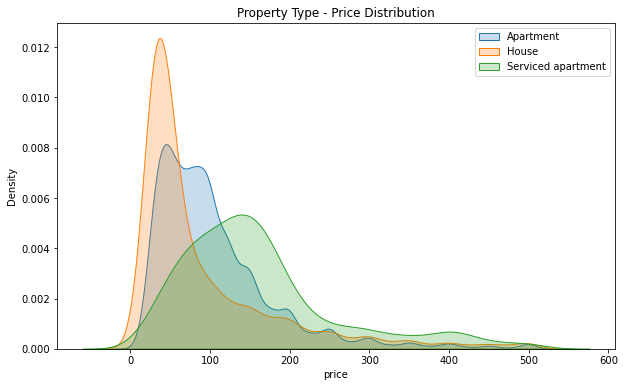

In [56]:
x = train[train['property_type'] == 'Apartment']['price']
y = train[train['property_type'] == 'House']['price']
z = train[train['property_type'] == 'Serviced apartment']['price']

fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(x, ax=ax, shade=True, label='Apartment')
sns.kdeplot(y, ax=ax, shade=True, label='House')
sns.kdeplot(z, ax=ax, shade=True, label='Serviced apartment')


plt.legend()
plt.title('Property Type - Price Distribution');

As the distributions vary quite drastically, we deduce that this variable carries a significant amount of information about a listing's price.

#### Room Type
Similarly, we have information on the room type of each listing. This varies from having to share a room with other guests to having an entire house to oneself. We suspect there to be a strong link between this variable and the target, which we will briefly investigate visually.

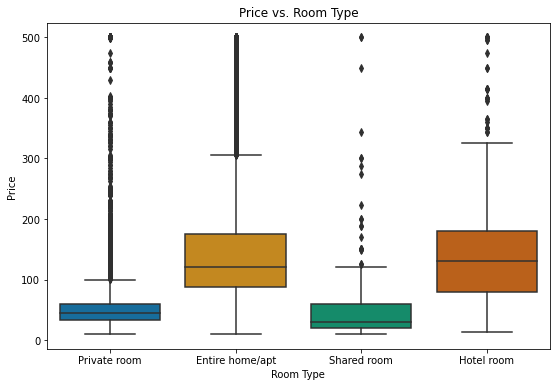

In [57]:
plt.figure(figsize=(9,6))

sns.boxplot(data=train, x='room_type', y='price', palette='colorblind')
plt.title('Price vs. Room Type')
plt.ylabel('Price')
plt.xlabel('Room Type');

The figure above confirms our intuition: The prices of private and shared rooms tend to be a lot lower than those of entire homes or apartments and hotel rooms.

#### Accommodates
As noted previously, the number of guests potentially accommodated by a listing shows a strong positive correlation with the price. Here, we will look into this relationship in more detail.

In [58]:
pd.DataFrame({'Nr. Obs.': train['accommodates'].value_counts(), 'Average Price': train.groupby('accommodates')['price'].agg('mean')})

,Nr. Obs.,Average Price
1,6915,44.135213
2,23678,72.233804
3,3878,99.117844
4,11059,135.754770
5,2597,164.163265
6,4359,185.918330
7,781,211.887324
8,1201,212.627810
9,241,250.966805
10,291,248.395189


Looking at the table above, we note a clear upwards trend in the average price as the number of guests a listing is noted to be able to accommodate increases. We also note that most listings can accommodate between one and eight guests, with two guests being by far the most common. Below, we visualize this table.

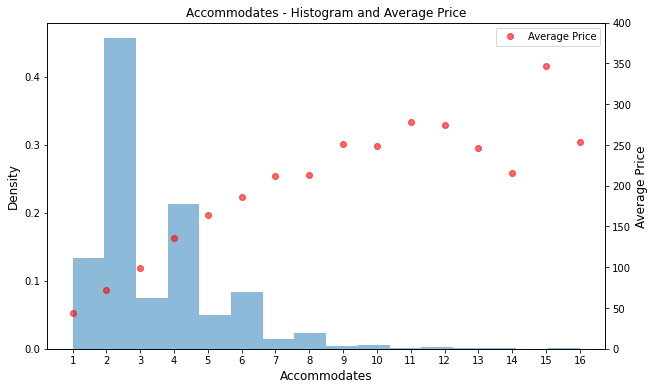

In [59]:
fig, ax = plt.subplots(figsize=(10,6))

ax.hist(train.accommodates, bins=16, density=True, alpha=0.5)
ax.set_xlabel("Accommodates", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
plt.xticks(np.arange(0, 17, 1.0))

ax2 = ax.twinx()
ax2.plot(train.groupby('accommodates')['price'].agg('mean'), linestyle='', marker='o', color='red', alpha=0.6, label='Average Price')
ax2.set_ylabel("Average Price",fontsize=12)
plt.ylim(0, 400)

plt.title('Accommodates - Histogram and Average Price')
plt.legend();

Notably, we observe a very clear linear relationship between the two variables, which then flattens before becoming diffused, caused by the small number of listings on the upper end of the spectrum.

#### Amenities
After transforming the list of included amenities for each listing into proper features above, we will now graphically examine how the price distribution differs between listings that do and do not include selected amenities.

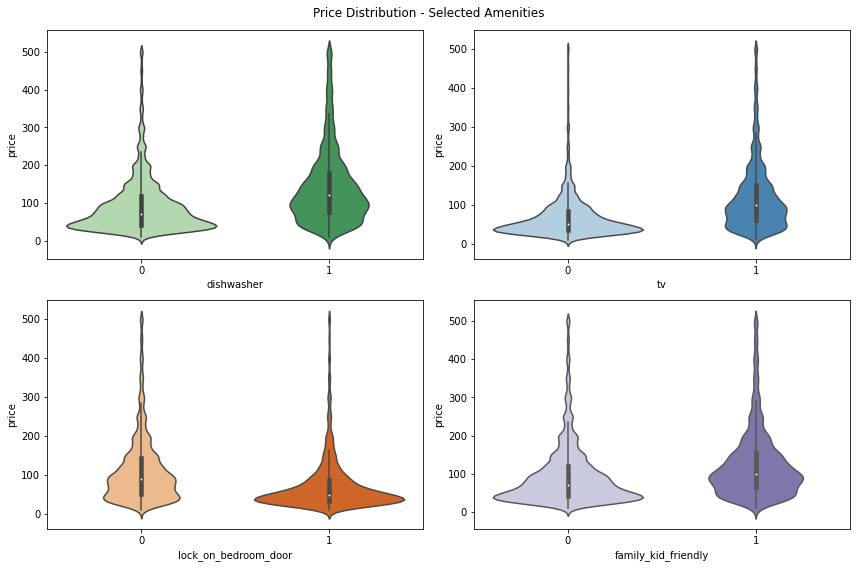

In [60]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,8))

fig.suptitle('Price Distribution - Selected Amenities')
sns.violinplot(data=train, x='dishwasher', y='price', ax=ax1, palette='Greens')
sns.violinplot(data=train, x='tv', y='price', ax=ax2, palette='Blues')
sns.violinplot(data=train, x='lock_on_bedroom_door', y='price', ax=ax3, palette='Oranges')
sns.violinplot(data=train, x='family_kid_friendly', y='price', ax=ax4, palette='Purples')

plt.tight_layout();

For the amenities dishwasher, TV, and 'family/kid-friendly', we observe similar patterns, where listings with these amenities tend to have a higher price, as indicated by a price distribution that is shifted upwards. For listings with a lock on the bedroom door, this relationship is reversed: Those with it tend to have a significantly lower price than those without. Bedroom door locks tend to be common for listings that are private rooms, where they are used to increase privacy and security, which, as we have seen before, tend to be less expensive on average.

Generally, the patterns we observe here follow our expectations, since most amenities tend to add to a listing's price.

#### Review Scores Location
An Airbnb's location is important to its guests. We now investigate the link between how guests rate a listing's location, the Airbnb's distance from the city center, and its average price.

In [61]:
pd.DataFrame({'Nr. Obs.': train['review_scores_location'].value_counts(),
              'Average Distance from Center': train.groupby('review_scores_location')['distance_from_center'].agg('mean').round(2),
              'Average Price': train.groupby('review_scores_location')['price'].agg('mean').round(2)})

,Nr. Obs.,Average Distance from Center,Average Price
2.0,85,9.49,84.26
3.0,1,2.22,57.00
4.0,51,8.62,92.31
5.0,20,11.88,65.55
6.0,314,8.44,94.97
7.0,297,8.33,85.30
8.0,2397,7.96,86.67
9.0,11128,7.61,87.14
10.0,27511,6.45,108.13


Evidently, guests tend to give a better location rating to listings that are closer to the city center. These listings are also more expensive on average.

#### Distance from City Center
Examining an Airbnb's price versus its distance from the city center, we notice a trend of listings tending to have a higher price if the distance is shorter. This is what we would expect given the typically higher demand for accommodations in the city center and the overall higher costs for housing in central areas. Additionally, we highlight the listings with zip code SW6, which we already had a brief look at previously. 

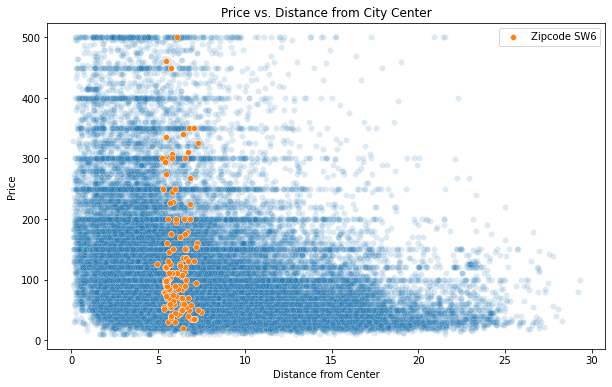

In [62]:
fig, ax = plt.subplots(figsize=(10,6))

temp = train.copy()
temp['sw6'] = (train['zipcode']=='SW6')

not_sw6 = temp[temp['sw6'] == False]
sw6 = temp[temp['sw6'] == True]

sns.scatterplot(data=not_sw6, x='distance_from_center', y='price', alpha=0.15, ax=ax)
sns.scatterplot(data=sw6, x='distance_from_center', y='price', ax=ax, label='Zipcode SW6')
plt.title('Price vs. Distance from City Center');
plt.ylabel('Price')
plt.xlabel('Distance from Center')
plt.legend();

The plot above further supports the trend we have observed thus far. It becomes quite obvious that, the farther away from London's center a listing, the lower its price tends to be. The listings with the zip code in question are located around the same distance from the center, as one would expect. We can observe that the price for listings with this zip code varies quite drastically. The high average price is also likely to be influenced by the three outliers that are clearly visible.

#### Review Sentiment
Having previously extracted the average review sentiment for each listing, we can now examine how the listing price differs by each value this variable can take. 

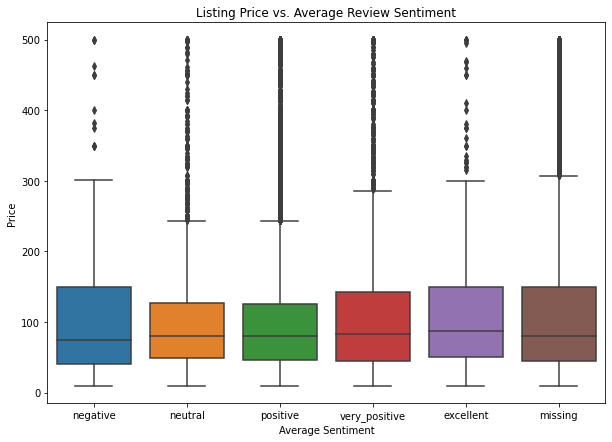

In [63]:
plt.figure(figsize=(10,7))

sns.boxplot(train.sentiment, train.price)
plt.title('Listing Price vs. Average Review Sentiment')
plt.ylabel('Price')
plt.xlabel('Average Sentiment');

In fact, the price does not appear to vary much, although we can notice a slightly higher average price for listings whose reviews are very positive or excellent. Generally, however, we could find arguments for both directions of the relationship between the two variables, and also for no connection at all. Although we are unconclusive about the link between average review sentiment and price, we decide to keep it as a feature.

### 3b. Feature Engineering <a name="feat_eng_nontext"></a> 
Above, we explored the relationship between selected variables and the target variable. Having done that, we are now ready to transform the data further by refining or re-engineering some of the features.

#### Neighbourhood
Noting that the number of distinct neighbourhoods is quite high, we see the potential to reduce this number by summarizing neighbourhoods that are similar with respect to their average distance from the city center and price into larger groups. We will leave most neighbourhoods that contain at least 1,000 listings as they are and primarily focus on the less popular ones to reduce the feature's cardinality. 

In [64]:
pd.DataFrame({'Nr. Obs.': train['neighbourhood_cleansed'].value_counts(),
              'Average Distance from Center': train.groupby('neighbourhood_cleansed')['distance_from_center'].agg('mean').round(2),
              'Average Price': train.groupby('neighbourhood_cleansed')['price'].agg('mean').round(2)}).sort_values('Nr. Obs.', ascending=False)[0:20]

,Nr. Obs.,Average Distance from Center,Average Price
Westminster,6011,2.89,158.06
Tower Hamlets,5434,5.82,88.24
Hackney,4135,5.94,88.27
Camden,3935,3.62,128.06
Kensington and Chelsea,3696,4.61,162.30
Islington,3284,4.36,105.76
Lambeth,3223,5.06,91.11
Southwark,3196,4.46,93.70
Wandsworth,2761,6.92,111.71
Hammersmith and Fulham,2656,6.55,113.62


In [65]:
train = pre.recode_neighbourhood(train)
test = pre.recode_neighbourhood(test)

#### Host - Total Listings Count
In the exploratory analysis, we already decided that it makes sense to transform the hosts' total listings count into a categorical variable. We perform this transformation here.

In [66]:
bins = [0, 1, 5, 1500]
labels = ['1', '2-5', '5+']

train['host_total_listings_count'] = pd.cut(train['host_total_listings_count'], bins=bins, labels=labels, include_lowest=True)
test['host_total_listings_count'] = pd.cut(test['host_total_listings_count'], bins=bins, labels=labels, include_lowest=True)

#### Property Type
We previously noted how the price distribution differs for the different property types. To deal with the high cardinality of this categorical feature, we will summarize the less common types into a single category.

In [67]:
train = pre.recode_property_type(train)
test = pre.recode_property_type(test)

#### Accommodates
As we saw during the correlation analysis earlier, this feature is highly correlated with the number of beds of a listing.

In [68]:
print('Correlation between \'accommodates\' and \'beds\':',train['accommodates'].corr(train['beds']).round(3))

Correlation between 'accommodates' and 'beds': 0.795


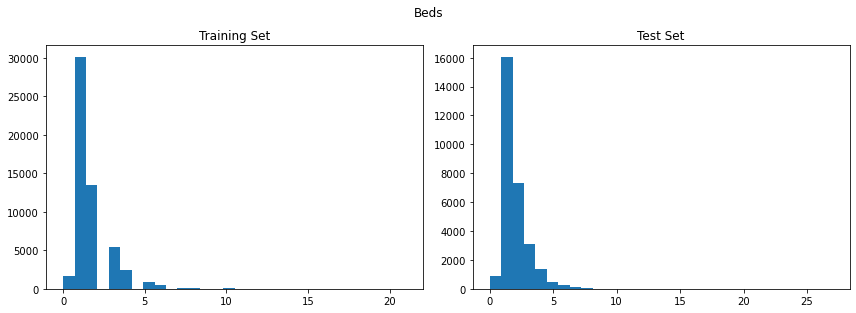

In [69]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)       
ax1.hist(train['beds'], bins=30)
ax1.title.set_text('Training Set')

ax2 = fig.add_subplot(222)
ax2.hist(test['beds'], bins=30)
ax2.title.set_text('Test Set')

fig.suptitle('Beds')
plt.tight_layout();

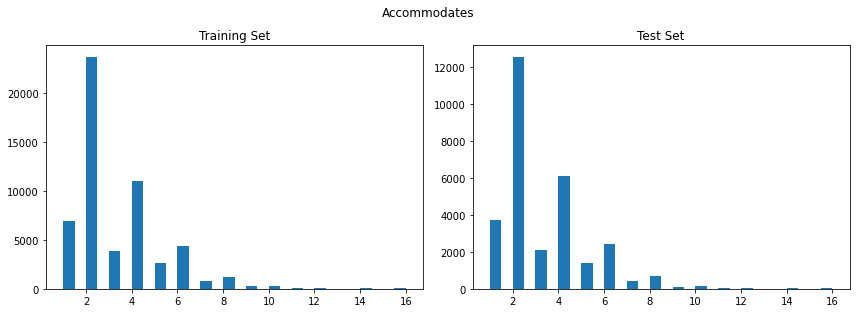

In [70]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)       
ax1.hist(train['accommodates'], bins=30)
ax1.title.set_text('Training Set')

ax2 = fig.add_subplot(222)
ax2.hist(test['accommodates'], bins=30)
ax2.title.set_text('Test Set')

fig.suptitle('Accommodates')
plt.tight_layout();

Looking at the distributions of both variables, we suspect the information about the number of people an Airbnb can accommodate to be at least as informative as the number of beds. Thus, we decide to keep the former and drop the latter from the dataset.

In [71]:
train.drop('beds', 1, inplace=True)
test.drop('beds', 1, inplace=True)

Additionally, because we see a clear pattern in the left plot above, we will transform this variable into a categorical feature.

In [72]:
bins = [0, 1, 2, 4, 6, 1500]
labels = ['1', '2', '3-4', '5-6', '7+']

train['accommodates'] = pd.cut(train['accommodates'], bins=bins, labels=labels, include_lowest=True)
test['accommodates'] = pd.cut(test['accommodates'], bins=bins, labels=labels, include_lowest=True)

#### Bathrooms
We proceed by also transforming the number of bathrooms into a categorical feature.

In [73]:
bins = [0, 0.9, 1.4, 2, 12]
labels = ['-1', '1', '1.5-2', '2+']

train['bathrooms'] = pd.cut(train['bathrooms'], bins=bins, labels=labels, include_lowest=True)
test['bathrooms'] = pd.cut(test['bathrooms'], bins=bins, labels=labels, include_lowest=True)

We will do the same for the number of bedrooms and the number of guests a listing includes.

#### Bedrooms

In [74]:
bins = [0, 0.9, 1, 2, 3, 12]
labels = ['0', '1', '2', '3', '>3']

train['bedrooms'] = pd.cut(train['bedrooms'], bins=bins, labels=labels, include_lowest=True)
test['bedrooms'] = pd.cut(test['bedrooms'], bins=bins, labels=labels, include_lowest=True)

#### Guests Included

In [75]:
bins = [0, 1, 2, 3, 4, 50]
labels = ['1', '2', '3', '4', '4+']

train['guests_included'] = pd.cut(train['guests_included'], bins=bins, labels=labels, include_lowest=True)
test['guests_included'] = pd.cut(test['guests_included'], bins=bins, labels=labels, include_lowest=True)

#### Bed Type
Since too few listings feature anything other than a real bed, we will drop this variable from the dataset.

In [76]:
train.drop('bed_type', 1, inplace=True)
test.drop('bed_type', 1, inplace=True)

#### Zip Code

In our previous analyses, we saw how the zip code carries a significant amount of information about an Airbnb listing's price. However, given the extremely high cardinality of this feature, leaving it in its current form would dramatically increase the dimensionality of our data. To mitigate this effect, we will perform Principal Component Analysis (PCA) to replace the zip code with three numeric factors. 

We will perform PCA on the training set first and then apply the fitted transformer on the test set in order to prevent data leakage.

In [77]:
train, test = pre.transform_zipcode(train, test)

#### Review Scores
Apart from the overall rating itself, all the 'review_scores' variables are very similar in their distribution within the training set. We decide to recode each feature into categories as we suspect the price to vary strongly between the resulting subgroups. This step will also help with dealing with missing values in these features down the line.

In [78]:
bins = [0, 94.9, 99, 101]
labels = ['-95', '95-99', '100']

train['review_scores_rating'] = pd.cut(train['review_scores_rating'], bins=bins, labels=labels, include_lowest=True)
test['review_scores_rating'] = pd.cut(test['review_scores_rating'], bins=bins, labels=labels, include_lowest=True)

In [79]:
bins = [0, 7.9, 8, 9, 11]
labels = ['-8', '8', '9', '10']

review_cols = ['review_scores_accuracy',
               'review_scores_cleanliness',
               'review_scores_checkin',
               'review_scores_communication',
               'review_scores_location',
               'review_scores_value']

for df in [train, test]:
    for col in review_cols:
        df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)

#### Cancellation Policy
Observing how few listings fall into certain categories of this variable, we decide to group the least common ones together.

In [80]:
cancellation_policy_dict = {
    **dict.fromkeys(['strict_14_with_grace_period'], 'strict_14_with_grace_period'),
    **dict.fromkeys(['flexible'], 'flexible'),
    **dict.fromkeys(['moderate'], 'moderate'),
    **dict.fromkeys(['super_strict_60', 'super_strict_30', 'strict', 'luxury_moderate', 'luxury_super_strict_95'], 'other')
    }

In [81]:
train['cancellation_policy'] = train['cancellation_policy'].map(cancellation_policy_dict)
test['cancellation_policy'] = test['cancellation_policy'].map(cancellation_policy_dict)

### 3c. Handling Missing Values and Final Processing <a name="missing_values_nontext"></a> 
In this section, we will be handling the missing values for the non-text features. We first inspect the total number of missing values for each variable and visualize them to make any patterns become apparent.

In [82]:
train.isna().sum()[train.isna().sum() > 0][7:]

host_response_time             17802
host_response_rate             17802
host_is_superhost                111
host_total_listings_count        111
host_identity_verified           111
neighbourhood_cleansed           782
property_type                     10
bathrooms                         70
bedrooms                          63
review_scores_rating           13415
review_scores_accuracy         13448
review_scores_cleanliness      13442
review_scores_checkin          13483
review_scores_communication    13446
review_scores_location         13480
review_scores_value            13480
reviews_per_month              12380
days_as_host                     111
dtype: int64

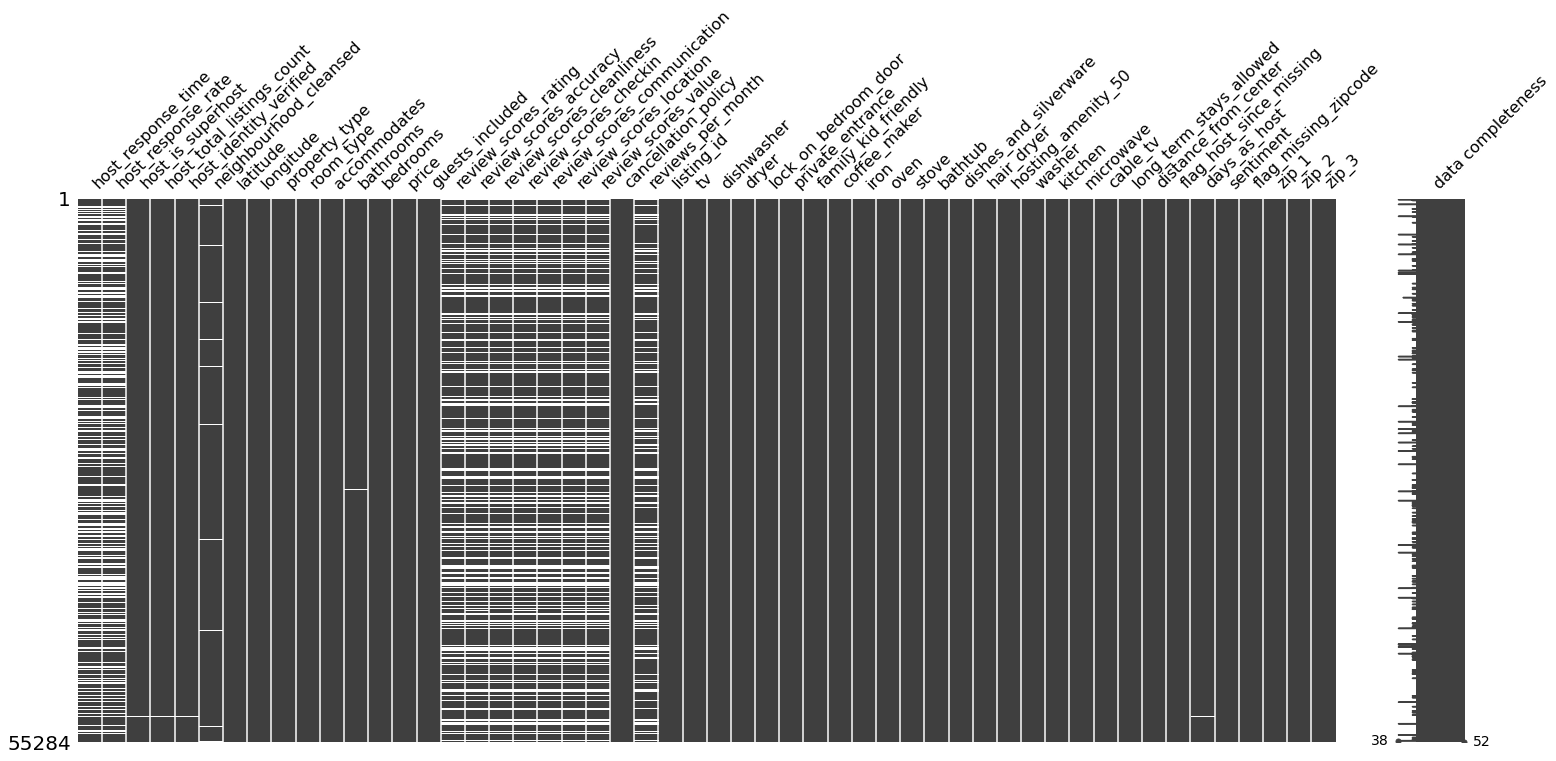

In [83]:
msno.matrix(train.iloc[:, 8:], labels=True);

Looking at the plot, we can clearly discern an identical pattern of missing values for hosts' response time and their response rate, as well as for all the variables related to the reviews. For these variables that do exhibit a pattern in the way values for them are missing, and for those variables for which we can assume that they are not missing at random, we will add a flag to indicate missing values. We will then impute the missing values for these observations with uninformative constants. All missing values that are missing at random and do not follow a noticeable pattern will be imputed using a nearest neighbour-based approach.

#### Host Response Time and Host Response Rate
As mentioned, we observe a clear pattern for the missing values of these variables. We can assume that, for these listings, their hosts have simply not received any or not enough messages.

In [84]:
train['flag_no_responses'] = (train['host_response_time'].isnull() & train['host_response_rate'].isnull()).astype(int)

train['host_response_time'].fillna('missing', inplace=True)
train['host_response_rate'].fillna(-1, inplace=True)

test['flag_no_responses'] = (test['host_response_time'].isnull() & test['host_response_rate'].isnull()).astype(int)

test['host_response_time'].fillna('missing', inplace=True)
test['host_response_rate'].fillna(-1, inplace=True)

#### Review Scores

For the review scores, we will look in detail at how many listings have no reviews at all, and at how many do have reviews but are missing the scores. This differentiation will allow for a different missing value treatment in the two cases.

In [85]:
print('====== Training set')
train = pre.analyze_missing_reviews(train)
print('\n====== Test set')
test = pre.analyze_missing_reviews(test)

====== Training set
Data contains:
- 12379 listing(s) without any reviews
- 1034 listing(s) with no review scores but documented reviews
- 1 listing(s) with review scores but no documented reviews

====== Test set
Data contains:
- 6627 listing(s) without any reviews
- 569 listing(s) with no review scores but documented reviews
- 1 listing(s) with review scores but no documented reviews


In cases where there is no indication that a listing has any reviews, we will treat them as missing not at random and impute the missing values with an uninformative constant. The missing values in all other cases will be considered missing at random (MAR) and treated accordingly.

In [86]:
train, test = pre.handle_missing_reviews(train, test)

#### Host Details
There appears to be a pattern of missing host details. We will quickly investigate whether this subgroup differs from the rest of the dataset in the distribution of the target variable before setting a flag to indicate missing values.

In [87]:
c_tr = ((train['host_is_superhost'].isnull()) & (train['host_total_listings_count'].isnull()) & (train['host_identity_verified'].isnull()) & (train['days_as_host'].isnull())).astype(int)
c_ts = ((test['host_is_superhost'].isnull()) & (test['host_total_listings_count'].isnull()) & (test['host_identity_verified'].isnull()) & (test['days_as_host'].isnull())).astype(int)

print(sum(c_tr),"listings are missing host details.")

111 listings are missing host details.


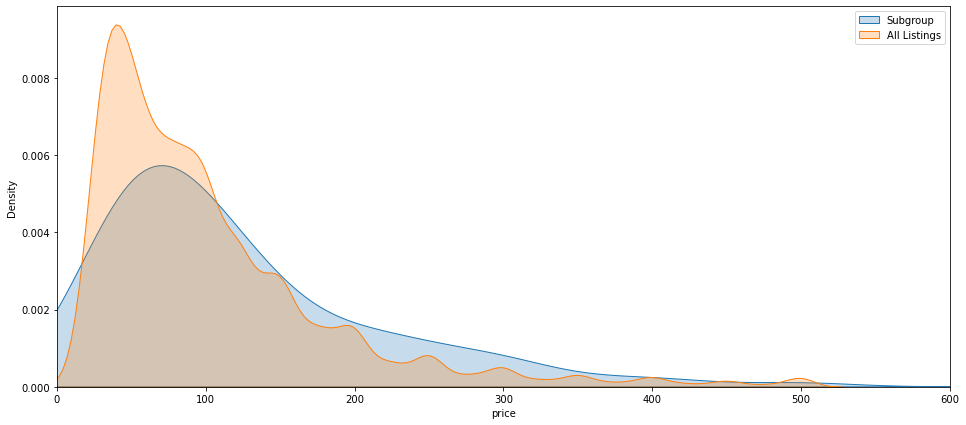

In [88]:
# distribution of price compared to overall distribution
x = train[c_tr.astype(bool)]['price']
y = train['price']

fig, ax = plt.subplots(figsize=(16, 7))

sns.kdeplot(x, ax=ax, label='Subgroup', shade=True)
sns.kdeplot(y, ax=ax, label='All Listings', shade=True)
plt.xlim(0,600)

plt.legend();

From the graph, we can see that the distributions do diverge quite a bit. However, the number of affected listings is small enough that it will not matter too much how we treat the missing values in these cases. Thus, we will simply treat them together with the other instances of MAR values.

In [89]:
train['flag_missing_host_details'] = c_tr
test['flag_missing_host_details'] = c_ts

In [90]:
# since this flag is perfectly correlated with another flag that was defined before, we drop that flag
train.drop('flag_host_since_missing', 1, inplace=True)
test.drop('flag_host_since_missing', 1, inplace=True)

#### Final Processing
Before we can impute the remaining missing values, we will separate the text and the non-text features and dummy-encode all categorical variables. Additionally, we will normalize the continuous features.

In [91]:
train = train.set_index('listing_id')
test = test.set_index('listing_id')

In [92]:
X_train_text = train.loc[:, 'name':'house_rules']
X_train_nontext = train.loc[:, 'host_response_time':'flag_missing_host_details'].drop('price', axis=1)

X_test_text = test.loc[:, 'name':'house_rules']
X_test_nontext = test.loc[:, 'host_response_time':'flag_missing_host_details']

In [93]:
X_train_nontext = pd.get_dummies(X_train_nontext)
X_test_nontext = pd.get_dummies(X_test_nontext)

In [94]:
cont_vars = ['latitude', 'longitude', 'reviews_per_month', 'distance_from_center', 'days_as_host']

scaler = StandardScaler()

X_train_nontext[cont_vars] = scaler.fit_transform(X_train_nontext[cont_vars])
X_test_nontext[cont_vars] = scaler.transform(X_test_nontext[cont_vars])

#### Missing Value Imputation
As noted before, we will be using a nearest neighbour-based approach, namely a kNN imputer, to impute the MAR values. The imputer will be fitted only on the training set to avoid data leakage.

In [95]:
imputer = KNNImputer(n_neighbors=5)

X_train_nontext = pd.DataFrame(imputer.fit_transform(X_train_nontext), columns = X_train_nontext.columns)

X_test_nontext = pd.DataFrame(imputer.transform(X_test_nontext), columns = X_test_nontext.columns)

## 4. Text Features <a name="text"></a>
In the following section, we have a closer look at the text features. This involves several preprocessing and cleaning steps, which are required before we can explore our data. We utilize the insights gained in this exploratory analysis in our final data preparation steps, which are needed before we can continue with building our first predictive models in the next section.

### 4a. Text Preprocessing <a name="text_preprocessing"></a>
The dataset contains text data spread out across several different features. Namely, these are the listing's name, the summary of its description, the full description, as well as details about the space, the neighbourhood, and transit. Finally, these features also include the house rules.

In [96]:
X_train_text.head()

,name,summary,space,description,neighborhood_overview,transit,house_rules
listing_id,,,,,,,
9Q1RD6H7IO,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...
6XDPZPGLSR,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...
SND9OPN6IY,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,NaN,NaN,1- No party or event allowed. 2-No smoking ins...
SE3B7BXN9G,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,"Your room will be fully furnished, and it will...",Luxury first floor Victorian split level maiso...,"Gail coffee shop, just round the corner as wel...",Happy to advise on things to do in London and ...,- Check-in after 18:30pm and no later than 20:...
E0C82VK0VF,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","A modern, well-equipped, cosy apartment close ...","NEW luxury apartment, with private outside pat...",NaN,NaN,"I am very happy for your visit, but please car..."


Looking at the first five listings' textual descriptions in the training set, we notice a relatively high share of missing values. This also holds for the test set.

In [97]:
print('Missing Values - Relative Frequency per Column\n')
print('='*45,'\n')
print(pd.DataFrame({'Training Set':(X_train_text.isna().sum()[:7]/len(X_train_text)*100).round(2),
              'Test Set': (X_test_text.isna().sum()[:7]/len(X_train_text)*100).round(2)}))

Missing Values - Relative Frequency per Column


                       Training Set  Test Set
name                           0.03      0.02
summary                        5.34      2.85
space                         30.54     16.38
description                    3.12      1.71
neighborhood_overview         35.28     19.09
transit                       35.83     19.30
house_rules                   42.29     22.76


Generally, missing text data does not pose an immediate problem. In the given problem context, a missing entry for, e.g., a listing's space description may simply mean that the host did not provide such a description. However, if the share of missing values for a variable is substantial, this may inhibit the performance of any predictive models that make use of this feature. </br>

Another point to take into consideration is the potential redundancy between the listing description and the summary of this description, which are two separate variables. There exists potentially further redundancy between the neighbourhood overview and the neighbourhood name, which was part of the previous analysis. Here, we would not expect the overview to add more information. Similarly, while the access to transit options appears relevant to a listing's price, its informational content is largely expected to be contained in the features related to a listing's location, which were dealt with above.
Additionally, a case can be made that some of the other text features comprised in the dataset provide little to no information about a listing's price. Notably, a link between the house rules and the target variable does not seem economically plausible.

Following this line of reasoning, we decide not to explore the descriptions of the space, the neighbourhood overview, the transit, and the house rules further in this analysis, as they exhibit a significant share of missing values and are expected to provide either redundant or generally little relevant information concerning a listing's price.

In [98]:
X_train_text.drop(['space', 'neighborhood_overview', 'transit', 'house_rules'], 1, inplace=True)
X_test_text.drop(['space', 'neighborhood_overview', 'transit', 'house_rules'], 1, inplace=True)

#### Cleaning
Before progressing further, the text features need to be cleaned. Among other problems, some listings' names are written in other languages than English. This needs to be dealt with together with all other issues to make the text features ready for processing in our predictive models. In order to do this, we perform several preprocessing steps. 

These steps are:
1. The removal of all non-ASCII characters,
2. The removal of all punctuation, upper casing, and words that include non-alphanumeric characters,
3. The removal of all English stopwords,
4. The removal of all infrequent words (words that occur only once within a text column),
4. The removal of all remaining single-letter words,
5. The removal of all unnecessary whitespace.

Before we actually perform the preprocessing steps, we need to deal with the missing values in the remaining text features. To this end, we will first define dummy flags that indicate any missing values for each variable before filling the missing values with empty strings.

In [99]:
X_train_text.head()

,name,summary,description
listing_id,,,
9Q1RD6H7IO,Attic Room in historic Greenwich,The room does not have a door but its own disc...,The room does not have a door but its own disc...
6XDPZPGLSR,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Garden studio with private entrance, 5 minutes..."
SND9OPN6IY,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN
SE3B7BXN9G,Luxury room in the heart of London - SW4,Luxury first floor Victorian split level maiso...,Luxury first floor Victorian split level maiso...
E0C82VK0VF,Excellent city Apartment with Private Patio,"NEW luxury apartment, with private outside pat...","NEW luxury apartment, with private outside pat..."


We are now ready to perform the text preprocessing. This is done in an external script (preprocess_text.py). We load the results of this process below.

In [100]:
X_train_text = pd.read_csv('data/processed/X_train_text_processed.csv', index_col='listing_id')
X_test_text = pd.read_csv('data/processed/X_test_text_processed.csv', index_col='listing_id')

In [101]:
X_train_text.iloc[:, 0:3].head()

,name,summary,description
listing_id,,,
9Q1RD6H7IO,attic room historic greenwich,room door discreet staircase light airy open p...,room door discreet staircase light airy open p...
6XDPZPGLSR,lovely garden studio private access,garden studio private entrance minute crouch e...,garden studio private entrance minute crouch e...
SND9OPN6IY,apartment close wimbledon tennis court,miss,miss
SE3B7BXN9G,luxury room heart london,luxury first floor victorian split level maiso...,luxury first floor victorian split level maiso...
E0C82VK0VF,excellent city apartment private patio,new luxury apartment private outside patio gre...,new luxury apartment private outside patio gre...


Finally, we deal with any newly-occurring missing values.

In [102]:
X_train_text = pre.flag_missing_text_features(X_train_text)
X_test_text = pre.flag_missing_text_features(X_test_text)

X_train_text.fillna('miss', inplace=True)
X_test_text.fillna('miss', inplace=True)

### 4b. Data Exploration <a name="dataexplor_text"></a>
Before diving into the final preparation steps required prior to building the predictive models, we will quickly examine the text features in more detail.

#### Text Lengths

In [103]:
text_lengths = pd.DataFrame({'name': 0, 'summary': 0, 'description': 0}, index=X_train_text.index)

In [104]:
text_lengths['name'] = X_train_text.name.apply(lambda x: len(str(x).split()))
text_lengths['summary'] = X_train_text.summary.apply(lambda x: len(str(x).split()))
text_lengths['description'] = X_train_text.description.apply(lambda x: len(str(x).split()))

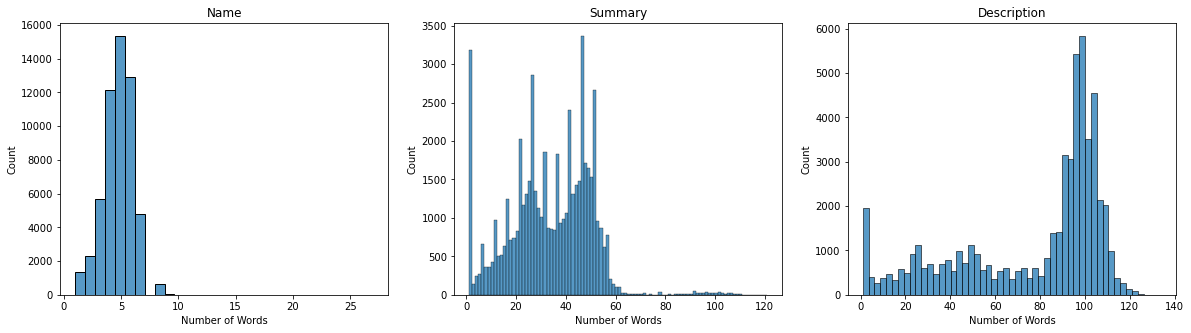

In [105]:
plt.figure(figsize=(20,5))

plt.subplot(131)
sns.histplot(text_lengths.name, bins=30)
plt.xlabel('Number of Words')
plt.title('Name');

plt.subplot(132)
sns.histplot(text_lengths.summary)
plt.xlabel('Number of Words')
plt.title('Summary');

plt.subplot(133)
sns.histplot(text_lengths.description)
plt.xlabel('Number of Words')
plt.title('Description');

Looking at the distribution of the number of words provides us insight into what the appropriate sequence length for each text feature should be, which we decide on definitively in the following preparation steps. It appears that most listings' name is no more than seven words long, while most summaries and descriptions are no longer than 60 and 120 words, respectively.

####  Most Common Words in Listing Names
In order to obtain a brief impression of the link between the text features and the target variable, we examine the most common words in the name of all listings, as well as in the top and bottom five percent of listings with respect to the price.

In [106]:
topfiveperc_value = np.percentile(train.price, 95, interpolation="higher")
topfiveperc_ix = train.index[np.where(train.price > topfiveperc_value)]

bottomfiveperc_value = np.percentile(train.price, 5, interpolation="lower")
bottomfiveperc_ix = train.index[np.where(train.price <= bottomfiveperc_value)]

In [107]:
def plot_most_common_words(text_col, title=""):
    split_it = text_col.apply(lambda x: Counter(x.split()).most_common())

    wordcounts = {}
    for ele in split_it:
        for word, count in ele:
            if word in wordcounts.keys():
                wordcounts[word] += count
            else:
                wordcounts[word] = count
                
    counts_df = pd.DataFrame({"word": list(wordcounts.keys()), "count": list(wordcounts.values())})
    counts_df.sort_values(by="count",ascending=False)[:20].plot.barh(x="word", title=title, figsize=(8,6)).invert_yaxis()
    plt.legend('', frameon=False)
    plt.xlabel('count');

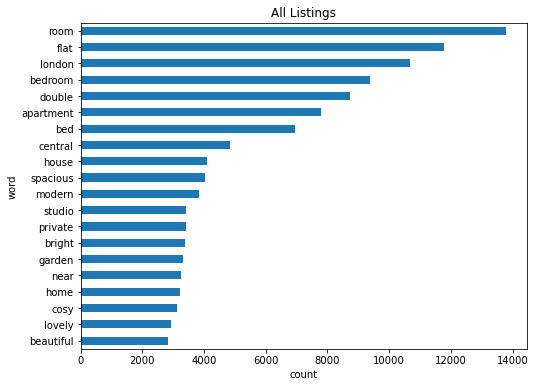

In [108]:
plot_most_common_words(X_train_text.name, "All Listings");

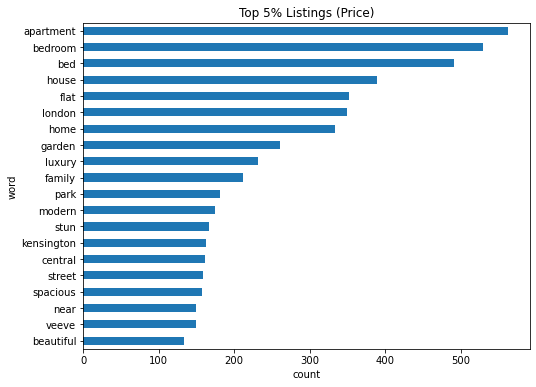

In [109]:
plot_most_common_words(X_train_text.name[topfiveperc_ix], "Top 5% Listings (Price)");

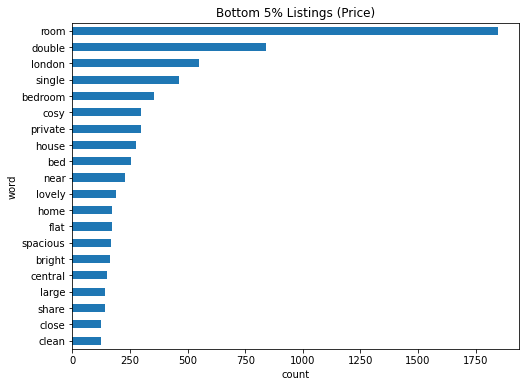

In [110]:
plot_most_common_words(X_train_text.name[bottomfiveperc_ix], "Bottom 5% Listings (Price)");

The most commonly appearing words in all listings are fairly similar to those in the bottom five percent. However, we also observe that 'single' tends to occur in many of the less expensive listings. This coincides with the link we found earlier between the number of beds or guests and a listing's price. In addition, the number of occurences of 'room', 'double', 'single' and 'flat' indicates that the least expensive listings tend to be private rooms and not entire apartments. This is rather reversed for the most expensive listings, where 'room' is not even among the most common words. Moreover, we notice a difference in the adjectives frequently used to describe the listings in each group. While the least expensive listings are 'cosy', 'lovely', or 'bright', the most expensive listings are portrayed as 'stunning' and 'luxurious'. In general, these observations are in line with our expectations and imply that the text features could be useful in predicting the target variable.

### 4c. Text Preparation <a name="text_preparation"></a>
Before proceeding with setting up the predictive models based on the text features, we need to further prepare our data. This includes shortening or padding them according to the sequence lengths we allow for each feature.
We then create an embedding matrix, a vectorizer, and finally the embedding layer for all three features. In this process we opt for using pretrained GloVe embeddings as it has been repeatedly shown that these drastically outperform any self-trained embeddings.

Below, we choose the sequence lengths for our text features based on our analysis in the section above.

In [111]:
OUTPUT_SEQ_LEN_NAME = 7
OUTPUT_SEQ_LEN_SUMMARY = 50
OUTPUT_SEQ_LEN_DESCRIPTION = 110

Now, we will load the pretrained GloVe embeddings, where we decided to use the 100-dimensional version. The embeddings were downloaded from https://nlp.stanford.edu/projects/glove/.

In [112]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "Documents/adams/exam/data/glove.6B.100d.txt"
)

embeddings_index = {}

with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


We first process the listing names.

In [113]:
X_train_name_emb = pre.text_embedding(X_train_text.name, OUTPUT_SEQ_LEN_NAME, embeddings_index)

In [114]:
vectorizer_name = X_train_name_emb.embedding_prep()

In [115]:
X_train_name_emb.get_embedding_matrix()

Converted 1097 words (40 misses).


Next, we prepare the embedding layer for this variable.

In [116]:
embedding_layer_name = X_train_name_emb.get_embedding_layer()

Successfully created embedding layer.


To conclude this part, we perform the same steps for the other two text features.

In [117]:
# summary
X_train_summary_emb = pre.text_embedding(X_train_text.summary, OUTPUT_SEQ_LEN_SUMMARY, embeddings_index)
vectorizer_summary = X_train_summary_emb.embedding_prep()
X_train_summary_emb.get_embedding_matrix()
embedding_layer_summary = X_train_summary_emb.get_embedding_layer()

# description
X_train_description_emb = pre.text_embedding(X_train_text.description, OUTPUT_SEQ_LEN_DESCRIPTION, embeddings_index)
vectorizer_description = X_train_description_emb.embedding_prep()
X_train_description_emb.get_embedding_matrix()
embedding_layer_description = X_train_description_emb.get_embedding_layer()

Converted 4085 words (117 misses).
Successfully created embedding layer.
Converted 6341 words (331 misses).
Successfully created embedding layer.


## 5. Model Building <a name="modeling"></a>
Finally, we are ready to build some models. After preparing our data for this step, we will first look at the non-text and text features separately to determine the best modeling approach for each individual set before bringing both together in a final model.

Throughout this section, we evaluate each model in terms of its root mean squared error (RMSE) and its mean absolute error (MAE). Generally, a low mean squared error (and consequently also RMSE) implies that a model is good at predicting cases in the target distribution's tails, while possibly more frequently making relatively small errors. It is thus rather sensitive to outliers compared to the MAE.

### 5a. Data Preparation <a name="data_prep"></a>
We split our non-text and text data into training and validation sets.

In [118]:
X_train_nontext.set_index(X_train_text.index, inplace=True)
X_test_nontext.set_index(X_test_text.index, inplace=True)

In [119]:
X_train_nontext[['flag_missing_name', 'flag_missing_summary', 'flag_missing_description']] = X_train_text[['flag_missing_name', 'flag_missing_summary', 'flag_missing_description']]
X_test_nontext[['flag_missing_name', 'flag_missing_summary', 'flag_missing_description']] = X_test_text[['flag_missing_name', 'flag_missing_summary', 'flag_missing_description']]

In [120]:
X_train_text.drop(['flag_missing_name', 'flag_missing_summary', 'flag_missing_description'], 1, inplace=True)
X_test_text.drop(['flag_missing_name', 'flag_missing_summary', 'flag_missing_description'], 1, inplace=True)

In [121]:
X_tr_1_nontext, X_val_1_nontext, y_tr_1, y_val_1 = train_test_split(X_train_nontext, train.price, test_size=0.125, random_state=42)
X_tr_1_text, X_val_1_text, y_tr_1, y_val_1 = train_test_split(X_train_text, train.price, test_size=0.125, random_state=42)

#### Saving the Datasets

In [122]:
with open('X_tr_1_nontext.pkl', 'wb') as file_name:
    pickle.dump(X_tr_1_nontext, file_name)
    
with open('X_val_1_nontext.pkl', 'wb') as file_name:
    pickle.dump(X_val_1_nontext, file_name)
    
with open('X_tr_1_text.pkl', 'wb') as file_name:
    pickle.dump(X_tr_1_text, file_name)  
    
with open('X_val_1_text.pkl', 'wb') as file_name:
    pickle.dump(X_val_1_text, file_name)
    
with open('y_tr_1.pkl', 'wb') as file_name:
    pickle.dump(y_tr_1, file_name)
    
with open('y_val_1.pkl', 'wb') as file_name:
    pickle.dump(y_val_1, file_name)
    
with open('X_tr_full_nontext.pkl', 'wb') as file_name:
    pickle.dump(X_train_nontext, file_name)
    
with open('X_tr_full_text.pkl', 'wb') as file_name:
    pickle.dump(X_train_text, file_name)

In [123]:
with open('y_train.pkl', 'wb') as file_name:
    pickle.dump(train.price, file_name)

In [124]:
with open('X_test_nontext.pkl', 'wb') as file_name:
    pickle.dump(X_test_nontext, file_name)
    
with open('X_test_text.pkl', 'wb') as file_name:
    pickle.dump(X_test_text, file_name)

### 5b. Non-Text Features <a name="models_nontext"></a>
To have an initial benchmark result, we first employ a linear regression combined with a penalty term in the form of Ridge regression. We use Ridge regression over a plain linear regression as, given the relatively high dimensionality of our data, we expect a significant increase in performance when applying a regularization term.  In order to obtain robust estimates of each model's performance, we use cross-validation to acquire both the RMSE, the MAE, and the $R^2$. We do see a substantial difference when we employ more elaborate algorithms in the form of a random forest regressor, for which we perform hyperparameter optimization via grid search, and two boosting-based algorithms, namely an XGB Regressor and a CatBoost Regressor, whose hyperparameters we tune using the same procedure. The latter two show the most promising results and perform very similarly. All results are displayed in the table below.

Considering the aforementioned high dimensionality of our dataset, we suspect that we could boost our performance to some extent by applying feature selection to reduce it. We make use of the built-in feature selection functionality of the CatBoost Regressor, which uses a threshold on the features' Shap values, to reduce the number of features from 140 down to 70. Feeding this pruned dataset into our two boosting-based regressors, we see a slight but noticeable increase in performance for both algorithms. Finally, to try one more modeling approach, we use a deep neural network combined with regularization via dropout layers and $L_2$ penalty terms. As we would have expected given the format of our data, the neural network performs relatively poorly in comparison with the boosting algorithms and the random forest, performing in fact just marginally better than our initial linear regression.

In [125]:
results_nontext = pd.read_csv('results_models_nontext.csv', index_col=0)
results_nontext[['RMSE', 'MAE', 'R-squared']] = results_nontext[['RMSE', 'MAE', 'R-squared']].round(2)

In [126]:
results_nontext

,Model Name,RMSE,MAE,R-squared
0,Ridge Regression,54.55,34.77,0.58
1,Random Forest Regressor,49.00,29.73,0.66
2,XGB Regressor,45.37,27.34,0.71
3,CatBoostRegressor,45.56,27.50,0.70
4,XGB Regressor (Feat. Sel.),45.46,27.38,0.71
5,CatBoostRegressor (Feat. Sel.),45.07,27.11,0.71
6,Deep Neural Network (Feat. Sel.),51.98,31.58,0.61


### 5c. Text Features <a name="models_text"></a>
For making predictions based on the text features, we will largely rely on recurrent neural networks. In a trial and error fashion, we test several GRU and LSTM configurations with static and trainable embeddings. Examining the table below, we see that the GRU-based networks perform only marginally better when used with trainable embeddings. On the other hand, employing trainable embeddings does boost the performance of all LSTM-based models considerably. The same holds for the convolutional neural network. However, the performance difference tends to not be as large as one would expect. This can be traced back to our preprocessing where we removed infrequently occuring words. Thus, we encounter only few out-of-vocabulary words, which explains why making the embeddings trainable does not result in a substantial performance improvement.

For each text feature, we train a separate model, which we then combine within one model architecture to receive a single model output for each observation. We try out several configurations for the number of hidden units and determine that 100 for the name and 200 for the summary and description work well for both the GRU and the LSTM layers. Within our networks, we make use of a non-linear activation function in the form of ReLu, which allows our networks to model more complex relationships.

In addition to varying the number of hidden units and layers of our models, we test different model architectures and feature subsets. We do the latter as we suspect some of the text features to carry more information about the target variable than others.

In summary, we try the following the model configurations:
* **GRU** - trained on the feature subsets *name/summary/description*, *name/description*, and *description*,
    each once with static and once with trainable embeddings
* **LSTM** - trained on the feature subsets *name/summary/description*, *name/description*, and *description*
* **Birectional LSTM** - trained on all text features
* **Deep LSTM** - trained on all text features
* **Convolutional Neural Network** - trained on the subset *name/description*

Generally, we notice that the text features are not nearly as informative as the non-text features, as even the best-performing model of this section performs poorly compared to the worst-performing model trained on the non-text features. Even though we did expect the text features to hold some information about the target, this result is reasonable: We can argue that, a priori, the name or description of an Airbnb is listing does not say much about its price as it is typically written by the host and naturally meant to attract guests. It is therefore usually formulated as positively as possible and tends to portray the listing in a better light than is really the case.
    
When looking in detail at how the models perform, we notice that a substantial share of them start overfitting very early into the training process. Analyzing the table below, we notice that there does not appear to be a clear trade-off between training time and model performance. In fact, the more complex and thus computationally more intensive models tend to be outperformed by the simpler contenders. It should be noted, however, that for our application, we are free to choose whichever "inefficient" model we prefer if it provides higher predictive accuracy, as the computation and prediction times are not restricted in any way. 

For our application, we choose a basic LSTM network trained on just the listing description as it performs well, while supposedly enabling us to capture more complex relationships among the text features in our more complex models down the line. A simple GRU model trained on the listing name and description seems like another viable candidate, but was later shown to be outperformed by the LSTM-based model.

In [127]:
results_text = pd.read_csv('results_models_text.csv', sep=',', index_col=0)
results_text[['Val. RMSE', 'Val. MAE']] = results_text[['Val. RMSE', 'Val. MAE']].round(2)

In [128]:
results_text

,Model,Features Considered,Training Time (min),Val. RMSE,Val. MAE
0,GRU (Static Emb.),"Name, Summary, Description",7.13,66.00,41.51
1,GRU (Trainable Emb.),"Name, Summary, Description",7.00,64.76,40.67
2,GRU (Static Emb.),"Name, Description",4.35,60.28,36.80
3,GRU (Trainable Emb.),"Name, Description",4.79,58.61,36.50
4,GRU (Static Emb.),Description,5.51,60.97,38.69
5,GRU (Trainable Emb.),Description,8.38,60.87,37.94
6,LSTM,"Name, Summary, Description",14.05,64.85,41.11
7,LSTM,"Name, Description",3.96,59.56,37.90
8,LSTM,Description,7.32,60.64,38.41
9,Bidirect. LSTM,"Name, Summary, Description",18.22,64.56,41.42


### 5d. All Features <a name="models_all"></a>
Having seen how models trained on the individual non-text and text datasets perform, we now want to utilize all available features within a single model architecture to obtain one final set of predictions. We will do this using three different approaches:

First, we try out naively combining all features back into a single dataset, where the text features are all vectorized, which we then feed into a model to obtain the final predictions. 
Second, we employ a stacking architecture that aims to make use of the best non-text model and the best text model, combining them using a meta model which is fitted on the other two models' output. 
Finally, we test a single neural network, which builds directly on the networks we used for predicting on the text features. In this approach, the non-text features will simply be treated as another input. 
   
#### *Naive Combination*

For this first approach, we will be using a CatBoost Regressor. We try out two alternatives, one using all text features and one using just the listing description. These text features are appended to the non-text features in matrix form. The method comes with some drawbacks, as the model is likely to ignore the text features and instead focus exclusively on the non-text features. In addition, the model is not capable of dealing with the sequence format of natural language nor of considering the word order. 

#### *Model Stacking*

Here, we train two models separately on the non-text and text data. The predictions obtained from these two models are then used to train a second-level meta model, whose output represents the final set of predictions. To judge the performance of this model without any bias stemming from data leakage, a rather complicated validation procedure would be required. We make use of a less complex and computationally less intensive approach, which still allows us to get a sound estimate of our model stack's performance, where we use our existing validation set while splitting the training set into a smaller training set and another validation set. These smaller sets are used to train and validate the first-level models, while the original validation set is used to train and validate the meta model using cross-validation. To facilitate this procedure, we opt for Ridge regression with built-in cross-validation as our second-level model.

#### *Concatenated Neural Network*

This last approach builds on one of the LSTM networks we used previously. It is enhanced by another input layer through which the non-text data is fed into the model. As we need to combine all inputs and allow the network to extract information from it, we will add several fully-connected layers, which we supplement with dropout regularization layers to mitigate any occuring overfitting.

#### Training and Test Set Preparation
For some of the following models, we will use the pruned non-text datasets, which we obtained using a feature selection procedure. We import these datasets here.

In [129]:
with open('X_tr_1_nontext_sel.pkl', 'rb') as file_name:
    X_tr_1_nontext_sel = pickle.load(file_name)    
    
with open('X_val_1_nontext_sel.pkl', 'rb') as file_name:
    X_val_1_nontext_sel = pickle.load(file_name)    
    
with open('X_tr_full_nontext_sel.pkl', 'rb') as file_name:
    X_tr_full_nontext_sel = pickle.load(file_name)
    
with open('X_test_nontext_sel.pkl', 'rb') as file_name:
    X_test_nontext_sel = pickle.load(file_name)

In [130]:
X_tr_2_nontext_sel, X_val_2_nontext_sel, y_tr_2, y_val_2 = train_test_split(X_tr_1_nontext_sel, y_tr_1, test_size=0.15, random_state=42)
X_tr_2_text, X_val_2_text, y_tr_2, y_val_2 = train_test_split(X_tr_1_text, y_tr_1, test_size=0.15, random_state=42)

We need to prepare the training and validation, as well as the test data so that it can be fed into the neural networks that we train shortly.

In [131]:
X_tr_1_text_name = vectorizer_name(np.array([[s] for s in X_tr_1_text.name])).numpy()
X_tr_1_text_summary = vectorizer_summary(np.array([[s] for s in X_tr_1_text.summary])).numpy()
X_tr_1_text_description = vectorizer_description(np.array([[s] for s in X_tr_1_text.description])).numpy()

X_val_1_text_name = vectorizer_name(np.array([[s] for s in X_val_1_text.name])).numpy()
X_val_1_text_summary = vectorizer_summary(np.array([[s] for s in X_val_1_text.summary])).numpy()
X_val_1_text_description = vectorizer_description(np.array([[s] for s in X_val_1_text.description])).numpy()

y_val_1 = np.array(y_val_1)

In [132]:
X_tr_2_text_description = vectorizer_description(np.array([[s] for s in X_tr_2_text.description])).numpy()
X_tr_2_text_name = vectorizer_name(np.array([[s] for s in X_tr_2_text.name])).numpy()

X_val_2_text_description = vectorizer_description(np.array([[s] for s in X_val_2_text.description])).numpy()
X_val_2_text_name = vectorizer_name(np.array([[s] for s in X_val_2_text.name])).numpy()

y_val_2 = np.array(y_val_2)

In [133]:
X_test_text_description = vectorizer_description(np.array([[s] for s in X_test_text.description])).numpy()

Additionally, we have to create the trainable embedding layer which we will use in our models.

In [134]:
embedding_layer_name_trainable = X_train_name_emb.get_embedding_layer(trainable=True)
embedding_layer_description_trainable = X_train_description_emb.get_embedding_layer(trainable=True)

Successfully created embedding layer.
Successfully created embedding layer.


#### Evaluation Metrics

In [135]:
model_name = []
val_RMSE = []
val_MAE = []
val_R2 = []

#### 5d.a. Naive Combination <a name="naive_comb"></a>
As stated above, we will merge the non-text and text data for this approach. In order to do this, we need to prepare the text data. We first do so for the training set.

In [136]:
name_df = pd.DataFrame(X_tr_1_text_name)
summary_df = pd.DataFrame(X_tr_1_text_summary)
description_df = pd.DataFrame(X_tr_1_text_description)

text_feats_df_tr_1 = pd.concat([name_df, summary_df, description_df], axis=1).set_index(X_tr_1_nontext.index)
text_feats_df_tr_1.columns = ['f'+str(x) for x in (range(0, 167))]

In [137]:
description_df_tr_1 = description_df.set_index(X_tr_1_nontext.index)
description_df_tr_1.columns = ['f'+str(x) for x in (range(0, 110))]

And now for the validation set.

In [138]:
name_df = pd.DataFrame(X_val_1_text_name)
summary_df = pd.DataFrame(X_val_1_text_summary)
description_df = pd.DataFrame(X_val_1_text_description)

text_feats_df_val_1 = pd.concat([name_df, summary_df, description_df], axis=1).set_index(X_val_1_nontext.index)
text_feats_df_val_1.columns = ['f'+str(x) for x in (range(0, 167))]

In [139]:
description_df_val_1 = description_df.set_index(X_val_1_nontext.index)
description_df_val_1.columns = ['f'+str(x) for x in (range(0, 110))]

Now, we are ready to create the concatenated training and validation sets. Once considering all text features and once with just the listing description.

In [140]:
df_tr_1 = pd.concat([X_tr_1_nontext, text_feats_df_tr_1], axis=1)
df_val_1 = pd.concat([X_val_1_nontext, text_feats_df_val_1], axis=1)

In [141]:
df_tr_1_sel = pd.concat([X_tr_1_nontext, description_df_tr_1], axis=1)
df_val_1_sel = pd.concat([X_val_1_nontext, description_df_val_1], axis=1)

With the prepared data, we can now fit our first model.

In [142]:
# CatBoostReg with all non-text features and all text features
catboost_params = {
    'iterations': 2000,
    'depth': 10,
    'learning_rate': 0.04,
    'l2_leaf_reg': 4,
    'early_stopping_rounds': 20,
    'use_best_model': True,
    'verbose': 0
}

cbr = CatBoostRegressor(**catboost_params)

cbr.fit(df_tr_1, y_tr_1, eval_set=(df_val_1, y_val_1), silent=True)

In [143]:
model_name.append('CatBoost Regressor (All Text)')
val_RMSE.append(np.sqrt(mean_squared_error(y_val_1, cbr.predict(df_val_1))))
val_MAE.append(mean_absolute_error(y_val_1, cbr.predict(df_val_1)))
val_R2.append(r2_score(y_val_1, cbr.predict(df_val_1)))

We then fit our second model on the data subset, using the same hyperparameter configuration as before.

In [144]:
# CatBoostReg with all non-text features and listing description
cbr = CatBoostRegressor(**catboost_params)

cbr.fit(df_tr_1_sel, y_tr_1, eval_set=(df_val_1_sel, y_val_1), silent=True)

In [145]:
model_name.append('CatBoost Regressor (Sel. Text)')
val_RMSE.append(np.sqrt(mean_squared_error(y_val_1, cbr.predict(df_val_1))))
val_MAE.append(mean_absolute_error(y_val_1, cbr.predict(df_val_1)))
val_R2.append(r2_score(y_val_1, cbr.predict(df_val_1)))

#### 5d.b. Model Stacking <a name="model_stacking"></a>
Note that for this approach we use the selected subset of non-text features as we found this to improve the overall performance.

In [146]:
# best model, non-text (CatBoost)
params = {'depth': 10,
         'early_stopping_rounds': 20,
         'iterations': 2000,
         'l2_leaf_reg': 3,
         'learning_rate': 0.035,
         'verbose': 0}

cbr = CatBoostRegressor(**params).fit(X_tr_2_nontext_sel, y_tr_2, silent=True)

In [147]:
# best model, text (LSTM - description)
input_description = Input(shape=(None, ))
embed_description = embedding_layer_description_trainable(input_description)
inter_description = LSTM(200)(embed_description) 
outputs = Dense(1)(inter_description)

model = Model(inputs=input_description, outputs=outputs)
model.compile(loss = 'mean_squared_error', optimizer = "RMSprop", metrics=['mae', me.root_mean_squared_error])

The optimal number of epochs was determined to be 11 when previously training this network configuration during the analysis of the text models.

In [148]:
model.fit(X_tr_2_text_description, y_tr_2,
                    epochs=11,
                    verbose=0, 
                    batch_size=128, 
                    shuffle=False,
                    workers=8,
                    use_multiprocessing=True)

In [149]:
y_pred_stacked = ms.stacked_prediction(cbr,
                                    model,
                                    X_val_2_nontext_sel, X_val_2_text_description, y_val_2,
                                    X_val_1_nontext_sel, X_val_1_text_description
                                    )

Ridge Regression coefficients: [0.88245565 0.1351124 ]


We can interpret the coefficients of the meta model as the approximate weights given to the first-level models' predictions. Evidently, most of the final predictions are determined by the non-text features, as we expected given the results of our previous analyses. However, the text features do appear to still have a significant influence on the final output.

In [150]:
model_name.append('Stacked Model')
val_RMSE.append(np.sqrt(mean_squared_error(y_val_1, y_pred_stacked)))
val_MAE.append(mean_absolute_error(y_val_1, y_pred_stacked))
val_R2.append(r2_score(y_val_1, y_pred_stacked))

#### 5d.c. Concatenated Neural Network <a name="conc_nn"></a>

In [151]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.01, restore_best_weights=True)]

In [152]:
# non-text features
input_nontext = Input(shape=(X_tr_1_nontext.shape[1], ))

# text feature - description
input_description = Input(shape=(None, ))
embed_description = embedding_layer_description_trainable(input_description)
inter_description = LSTM(200)(embed_description) 
dense_description = Dense(1)(inter_description)

# concatenate the individual models
concat = concatenate([dense_description, input_nontext])
inter = Dropout(0.2)(concat)
inter = Dense(512, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=123), kernel_regularizer=l2(0.025))(inter)
inter = Dropout(0.2)(inter)
inter = Dense(256, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=123), kernel_regularizer=l2(0.025))(inter)
inter = Dropout(0.2)(inter)
inter = Dense(128, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=123), kernel_regularizer=l2(0.025))(inter)
output = Dense(1)(inter)

model = Model(inputs=[input_description, input_nontext], outputs=output)
model.compile(loss = 'mean_squared_error', optimizer = "RMSprop", metrics=['mae', me.root_mean_squared_error])

In [153]:
history = model.fit([X_tr_1_text_description, X_tr_1_nontext], y_tr_1,
                    epochs=30,
                    verbose=0, 
                    batch_size=128,
                    shuffle=False,
                    validation_data=([X_val_1_text_description, X_val_1_nontext], y_val_1),
                    callbacks=callbacks,
                    workers=8,
                    use_multiprocessing=True)

Restoring model weights from the end of the best epoch: 12.
Epoch 15: early stopping


In [154]:
y_pred = model.predict([X_val_1_text_description, X_val_1_nontext])

model_name.append('Concatenated Neural Network')
val_RMSE.append(np.sqrt(mean_squared_error(y_val_1, y_pred)))
val_MAE.append(mean_absolute_error(y_val_1, y_pred))
val_R2.append(r2_score(y_val_1, y_pred))

#### Results
It is important to note that the performance metrics are not cross-validated, but simply reflect the models' performance on the originally defined validation set. If we were to use cross-validated performance scores, we would likely see the performance drop slightly.

In [155]:
results = pd.DataFrame({'Model Name': model_name, 'Val. RMSE': val_RMSE, 'Val. MAE': val_MAE, 'Val. R-squared': val_R2}); results

,Model Name,Val. RMSE,Val. MAE,Val. R-squared
0,CatBoost Regressor (All Text),45.618586,27.513628,0.702581
1,CatBoost Regressor (Sel. Text),47.513831,28.538647,0.677355
2,Stacked Model,44.244281,27.117692,0.720232
3,Concatenated Neural Network,48.493049,28.708329,0.663919


Examining the table, we note that the naive models perform at around the level we expected. Interestingly, the model considering all text features outperforms the one using just the description.
With the approach using a concatenated neural network, we are able to achieve a performance that exceeds our expectations, as it is significantly better than that of any of the neural networks trained previously on the non-text and text data individually. This indicates that the deep neural network is potentially able to extract additional information about the target when having access to both feature types. By far the best in terms of both the RMSE and the MAE on the validation set is the stacked model. It manages to outperform all models we have seen thus far.

Concluding the analysis of the results, we decide to proceed with the stacked model ensemble to obtain predictions for the test set.

#### Application to the Test Set
Last but not least, we are ready to use our finalized model architecture to predict the listing prices for the test set.

We first need to re-initialize our neural network.

In [156]:
input_description = Input(shape=(None, ))
embed_description = embedding_layer_description_trainable(input_description)
inter_description = LSTM(200)(embed_description) 
outputs = Dense(1)(inter_description)

model = Model(inputs=input_description, outputs=outputs)
model.compile(loss = 'mean_squared_error', optimizer = "RMSprop", metrics=['mae', me.root_mean_squared_error])

As we aim to predict on the test set and do not need another validation set, we are able to increase the amount of data that we use to train our models.

In [157]:
cbr = CatBoostRegressor(**params).fit(X_tr_1_nontext_sel, y_tr_1, silent=True)

model.fit(X_tr_1_text_description, y_tr_1,
                    epochs=11,
                    verbose=0, 
                    batch_size=128, 
                    shuffle=False,
                    workers=8,
                    use_multiprocessing=True)

We can now predict the prices and save the result to a submission file.

In [158]:
y_pred_stacked_kaggle = ms.stacked_prediction(cbr,
                                        model,
                                        X_val_1_nontext_sel, X_val_1_text_description, y_val_1,
                                        X_test_nontext_sel, X_test_text_description
                                        )

Ridge Regression coefficients: [0.9098734  0.11158264]


In [160]:
submission = pd.DataFrame(y_pred_stacked_kaggle, columns=['price'], index=X_test_nontext.index)
submission.to_csv('submissions/submission_stacked_model.csv')

## 6. Conclusion <a name="conclusion"></a>
In this analysis, we tried to predict the prices of Airbnb listings in London using a variety of tabular and text features. Our analysis comprised an extensive data preprocessing part, which was split into data cleaning, feature extraction and engineering, and data preparation. These preprocessing steps were followed by a review of several modeling approaches, separated by feature type, where we made use of a variety of machine learning algorithms, including neural networks suited for natural language processing. Using the insights gained during this process, we then assembled a selection of final models. Finally, we used one of these models to obtain our predictions of the listing prices for the test set.

Throughout this analysis, we found the text features to not hold as much predictive power as the tabular data.
However, combining both data types, we were able to create models that outshone those previously trained on both individual feature sets. In summary, we achieved our goal of building a well-performing model which makes use of a diverse set of features.

In future work, we could improve our analysis by preventing data leakage occuring during the preprocessing of our text features. Here, we would need to process the training and validation subsets separately. Furthermore, we could try even more elaborate state-of-the-art models for text processing such as BERT to enhance our predictive model.